# Visualizing What Convolutional Neural Networks Learn

The following notebook explores convolutional neural networks and their applications to the Fashion MNIST Dataset. The models' understanding of this dataset is interpreted through visualizations of the activations in the convolutional layers, and the impact of Dropout regularization is also investigated as a way to ensure that what the model is learning is generalizable to unseen data. 

# Packages

In [ ]:
import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#tensorflow
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Data Loading and Exploration

## Functions

In [ ]:
#plotting samples from the dataset
def plotImages(imgs, labels):
  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

  fig = plt.figure(figsize=(15,9))

  for i in range(len(imgs)):
    plt.subplot(5,10,i+1)
    plt.title(class_names[labels[i]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i].reshape(28,28), cmap='binary')


''' This function is for visualizing the pixel values in a matrix format.
    Since the images are in grayscale, the matrix visualization shows a rough outline of the object in the image.'''

def img_array_print(imgs, labels):
  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  np.set_printoptions(linewidth=np.inf)
  for i in range(len(imgs)):
    print(class_names[labels[i]].upper())
    print(f'{imgs[i]}')
    print('====================================================================================================================')
    print('====================================================================================================================\n\n')

## Loading and Exploration

In [ ]:
# loading Fashion MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print(f'Test Images Shape:  {test_images.shape}')
print(f'Test Labels Shape:  {test_labels.shape}')

4423680/4422102 [==============================] - 0s 0us/step
Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape:  (10000, 28, 28)
Test Labels Shape:  (10000,)


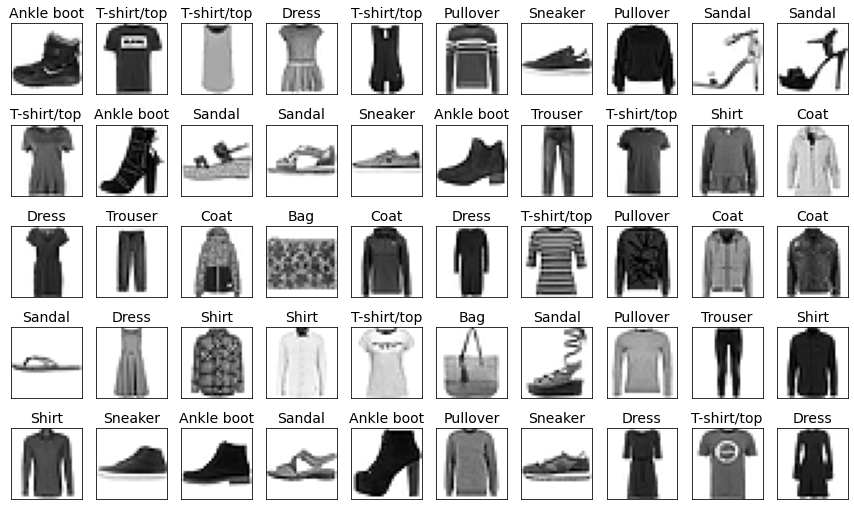

In [ ]:
# plotting sample of images in training set and their labels
plotImages(train_images[:50], train_labels[:50])

In [ ]:
# matrics of pixel values
img_array_print(train_images[:3],train_labels[:3])

ANKLE BOOT
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233

## Preprocessing

Here, the images are normalized, and a vaildation set is created from the training set.

In [ ]:
# normalizing pixel values
train_images = train_images.reshape((60_000,28,28,1))
train_images_norm = train_images.astype('float32')/255.

test_images = test_images.reshape((10_000, 28, 28, 1))
test_images_norm = test_images.astype('float32')/255.

#creating validation set
val_images_norm, train_images_norm = train_images_norm[:10_000], train_images_norm[10_000:]
val_labels, train_labels = train_labels[:10_000], train_labels[10_000:]

print(f'Validation Set Shape   : {val_images_norm.shape}')
print(f'Validation Labels Shape: {val_labels.shape}')

Validation Set Shape   : (10000, 28, 28, 1)
Validation Labels Shape: (10000,)


# Modeling

This section goes into the modeling of the Fashion MNIST Dataset, the visualization of activations, and the implementation of integrated gradients.

## Hyperparameters

In [ ]:
epochs=30
batch_size=512

## Modeling Functions

In [ ]:
#for checking whether or not the model is overfitting
def evaluate_model(model, history, epochs):
  loss, accuracy = model.evaluate(test_images_norm, test_labels)
  print(f'Test Set Accuracy: {round(accuracy*100,2)}')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  plt.figure(figsize=(12,4))

  for i,metrics in enumerate(zip([acc,loss], [val_acc,val_loss], ['Accuracy','Loss'])):
    plt.subplot(1,2,i+1)
    plt.plot(range(epochs), metrics[0], label=f'Training {metrics[2]}')
    plt.plot(range(epochs), metrics[1], label=f'Validation {metrics[2]}')
    plt.legend()

  plt.show()


#also for evaluating the model's goodness of fit
def heatmap_cm(model):
  
  pred_classes = np.argmax(model.predict(test_images_norm), axis=-1)
  conf_mx = confusion_matrix(test_labels, pred_classes)

  fig, axs = plt.subplots(1, 2, figsize=(16,6))

  axs[0].matshow(conf_mx, cmap=plt.cm.gray)
  axs[0].set_xlabel('Predicted Classes')
  axs[0].set_ylabel('Actual Classes')
  axs[0].set_title('Heatmapped Confusion Matrix')

  row_sums = tf.reduce_sum(conf_mx, axis=1)
  norm_conf_mx = np.matrix(conf_mx/row_sums)

  np.fill_diagonal(norm_conf_mx, 0)
  axs[1].matshow(norm_conf_mx, cmap=plt.cm.gray)
  axs[1].set_xlabel('Predicted Classes')
  axs[1].set_ylabel('Actual Classes')
  axs[1].set_title('Normalized Heatmapped Confusion Matrix')

  plt.show()


# the next two functions are for visualizing how the model behaves with respect to two particular classes 
def plot_digits(instances, pos, images_per_row=5, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size,size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size*n_empty)))
  for row in range(n_rows):
    rimages = images[row*images_per_row : (row+1)*images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
  image = np.concatenate(row_images, axis=0)
  pos.imshow(image, cmap='binary', **options)
  pos.axis('off')


def plot_clothes(model, cl_a, cl_b):
  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  pred_classes = np.argmax(model.predict(test_images_norm), axis=-1)

  X_aa = test_images_norm[(test_labels == cl_a) & (pred_classes == cl_a)]
  X_ab = test_images_norm[(test_labels == cl_a) & (pred_classes == cl_b)]
  X_ba = test_images_norm[(test_labels == cl_b) & (pred_classes == cl_a)]
  X_bb = test_images_norm[(test_labels == cl_b) & (pred_classes == cl_b)]

  plt.figure(figsize=(28,28))

  p1 = plt.subplot(221)
  p2 = plt.subplot(222)
  p3 = plt.subplot(223)
  p4 = plt.subplot(224)

  plot_digits(X_aa[:25], p1, images_per_row=5);
  plot_digits(X_ab[:25], p2, images_per_row=5);
  plot_digits(X_ba[:25], p3, images_per_row=5);
  plot_digits(X_bb[:25], p4, images_per_row=5);

  p1.set_title(f"{class_names[cl_a]}s classified as {class_names[cl_a]}s")
  p2.set_title(f"{class_names[cl_a]}s classified as {class_names[cl_b]}s")
  p3.set_title(f"{class_names[cl_b]}s classified as {class_names[cl_a]}s")
  p4.set_title(f"{class_names[cl_b]}s classified as {class_names[cl_b]}s")

  plt.show()


# plots the activation values in the model's convolutional layers
def conv_layer_plots(model, class_label):
  (_,_), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
  idx = np.argwhere(test_labels==class_label)[0][0]

  img, label = test_images[idx], test_labels[idx]
  class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

  layer_outputs = [layer.output for layer in model.layers]
  activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

  layer_names=[]
  for layer in model.layers:
    layer_names.append(layer.name)

  plt.imshow(img, cmap='binary')
  plt.axis('off')
  plt.title(class_names[label], fontsize=12)
  
  
  img_tensor = tf.keras.preprocessing.image.img_to_array(img)
  img_tensor = tf.expand_dims(img_tensor, axis=0)

  activations = activation_model.predict(img_tensor)

  images_per_row=16

  for layer_name, layer_activation in zip(layer_names[:5], activations[:5]):
    if layer_name == 'flatten':
      break

    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))

    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = layer_activation[0, :, :, col*images_per_row+row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col*size : (col+1)*size, row*size : (row+1)*size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

  plt.show()

## Dense Neural Networks

This next section of the notebook explores the use of dense neural networks for classifying images in the Fashion MNIST Dataset. The models in this section serve as a sort of performance baseline upon which the convolutional neural networks in the following section ought to improve. This section includes two pairs of two models with and without dropout regularization. 

### DNN with 2 Layers and No Dropout

In [ ]:
model = tf.keras.Sequential([ 
                             tf.keras.Input(shape=(28,28,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256,activation = 'relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(10)])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
98/98 [==============================] - 1s 5ms/step - loss: 0.9658 - accuracy: 0.6772 - val_loss: 0.5092 - val_accuracy: 0.8185
Epoch 2/30
98/98 [==============================] - 0s 4ms/step - loss: 0.4438 - accuracy: 0.8442 - val_lo

313/313 [==============================] - 1s 2ms/step - loss: 0.3503 - accuracy: 0.8897
Test Set Accuracy: 88.97


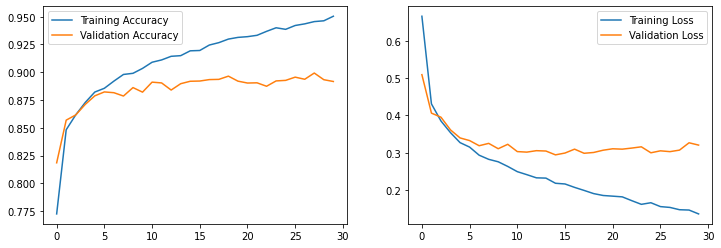

In [ ]:
evaluate_model(model, history, epochs)

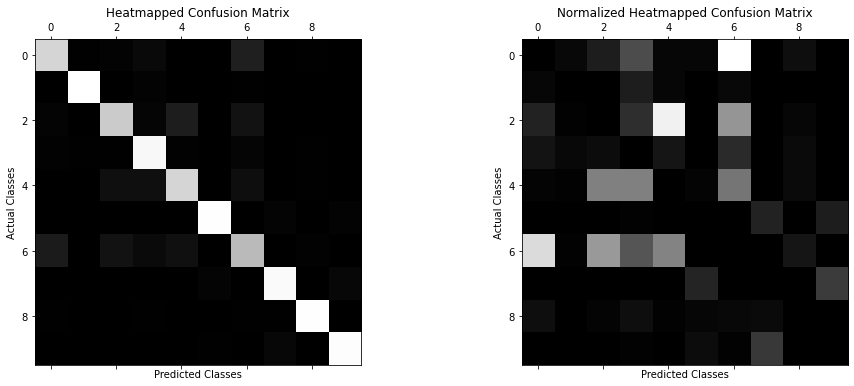

In [ ]:
heatmap_cm(model)

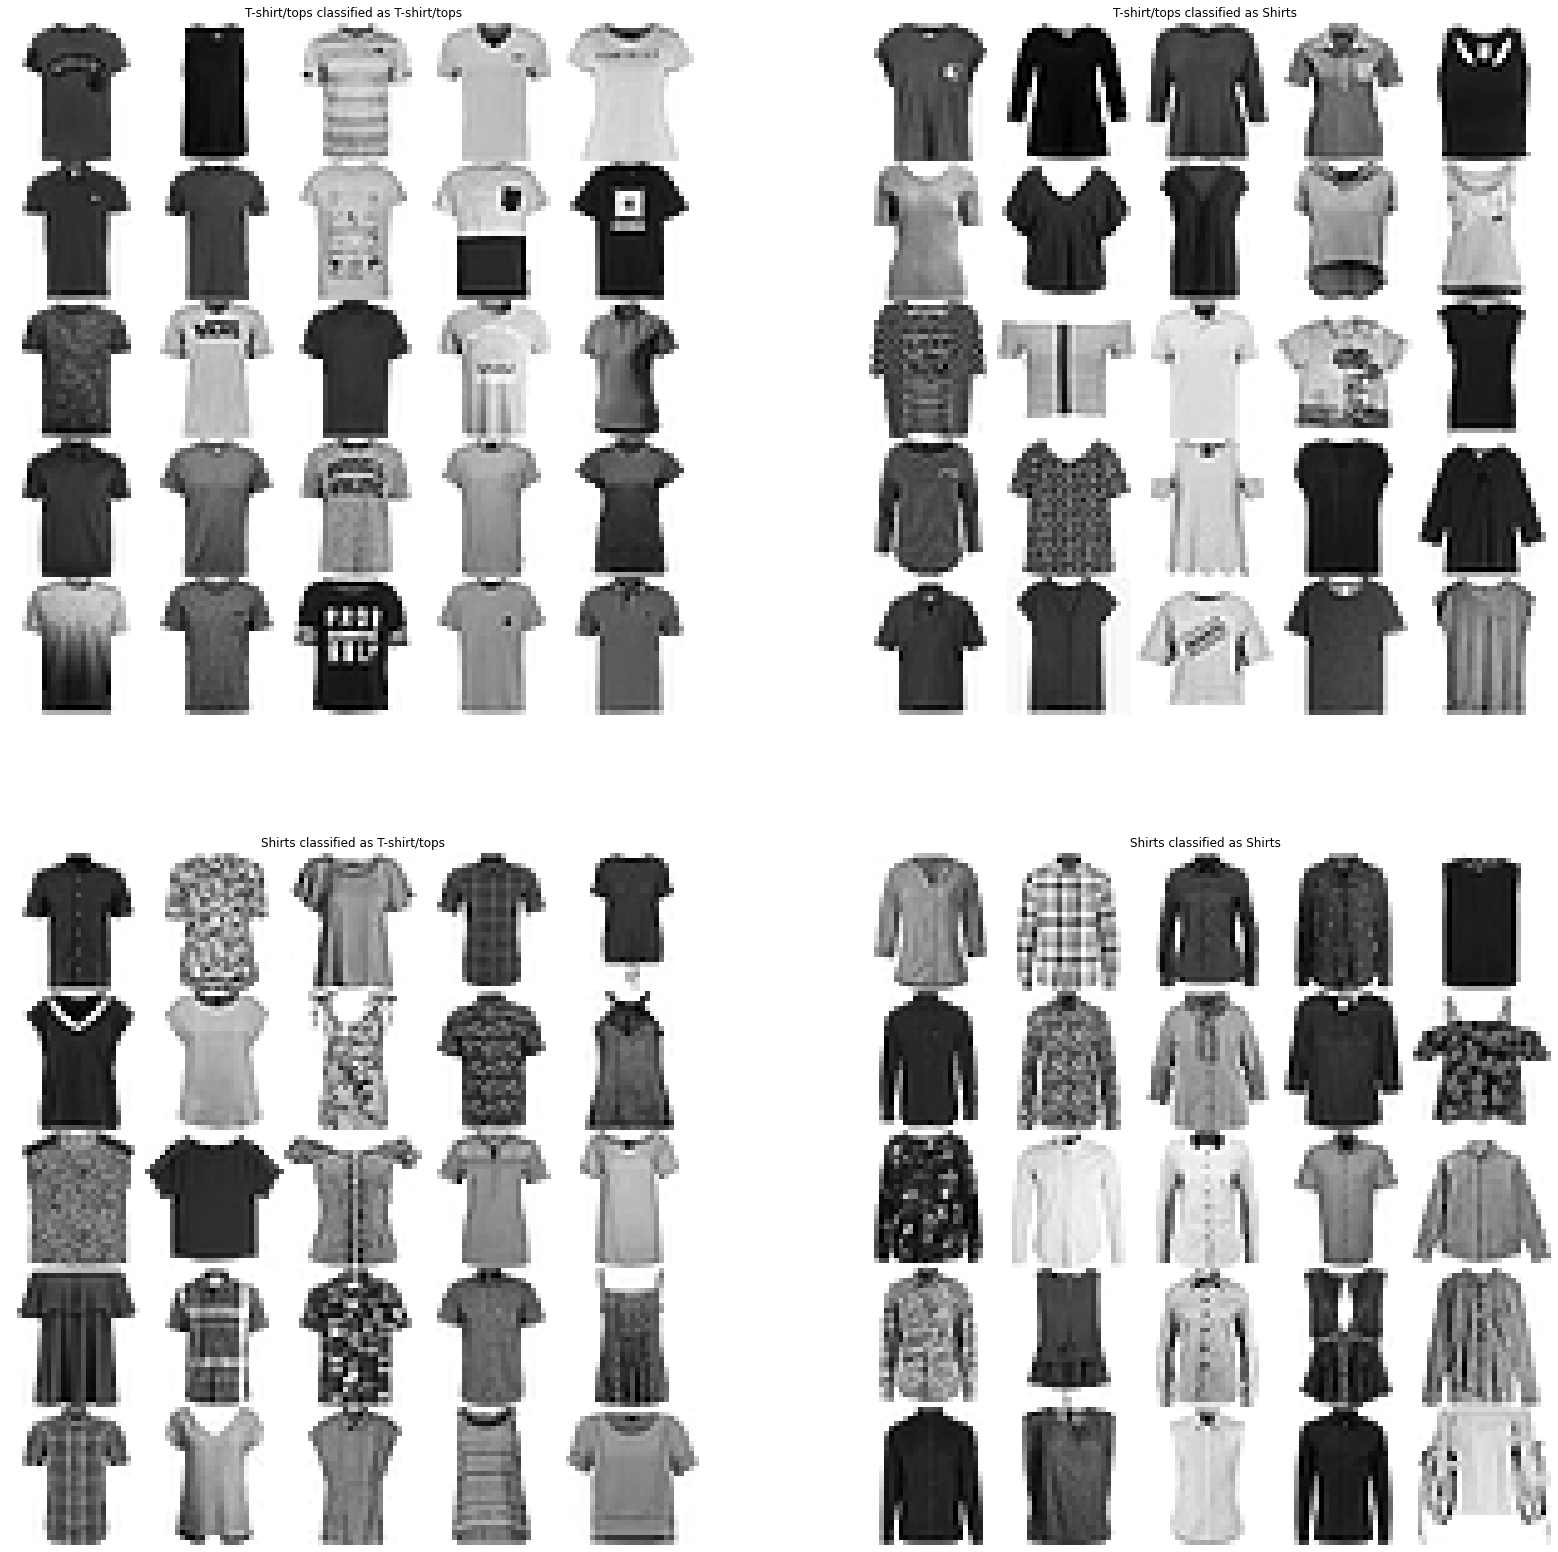

In [ ]:
plot_clothes(model, 0, 6)

Based upon the accuracy and loss plots, this model is overfitting by a good amount and should perform better with regularization. The confusion matrices also show that the model has difficulty distinguishing between the 'Shirt' and 'T-shirt/tops' classes. It seems that part of what the model is keying in on to make this determinations is the presence of sleeves on these types of clothing.


### DNN with 2 Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([ 
                             tf.keras.Input(shape=(28,28,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256,activation = 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
________________________________________________

313/313 [==============================] - 1s 2ms/step - loss: 0.3208 - accuracy: 0.8924
Test Set Accuracy: 89.24


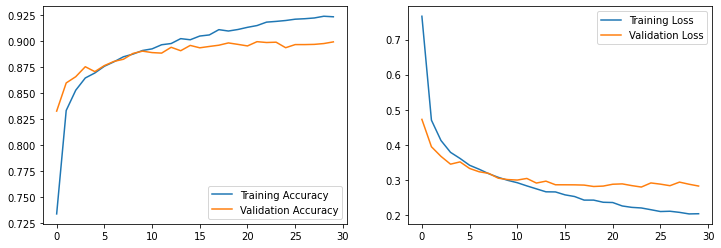

In [ ]:
evaluate_model(model, history, epochs)

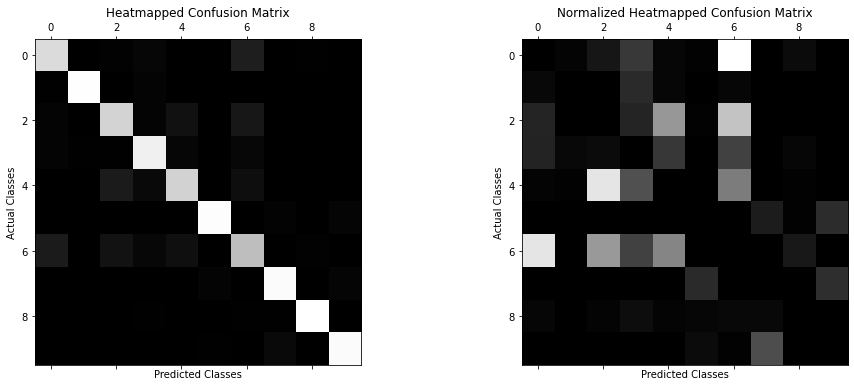

In [ ]:
heatmap_cm(model)

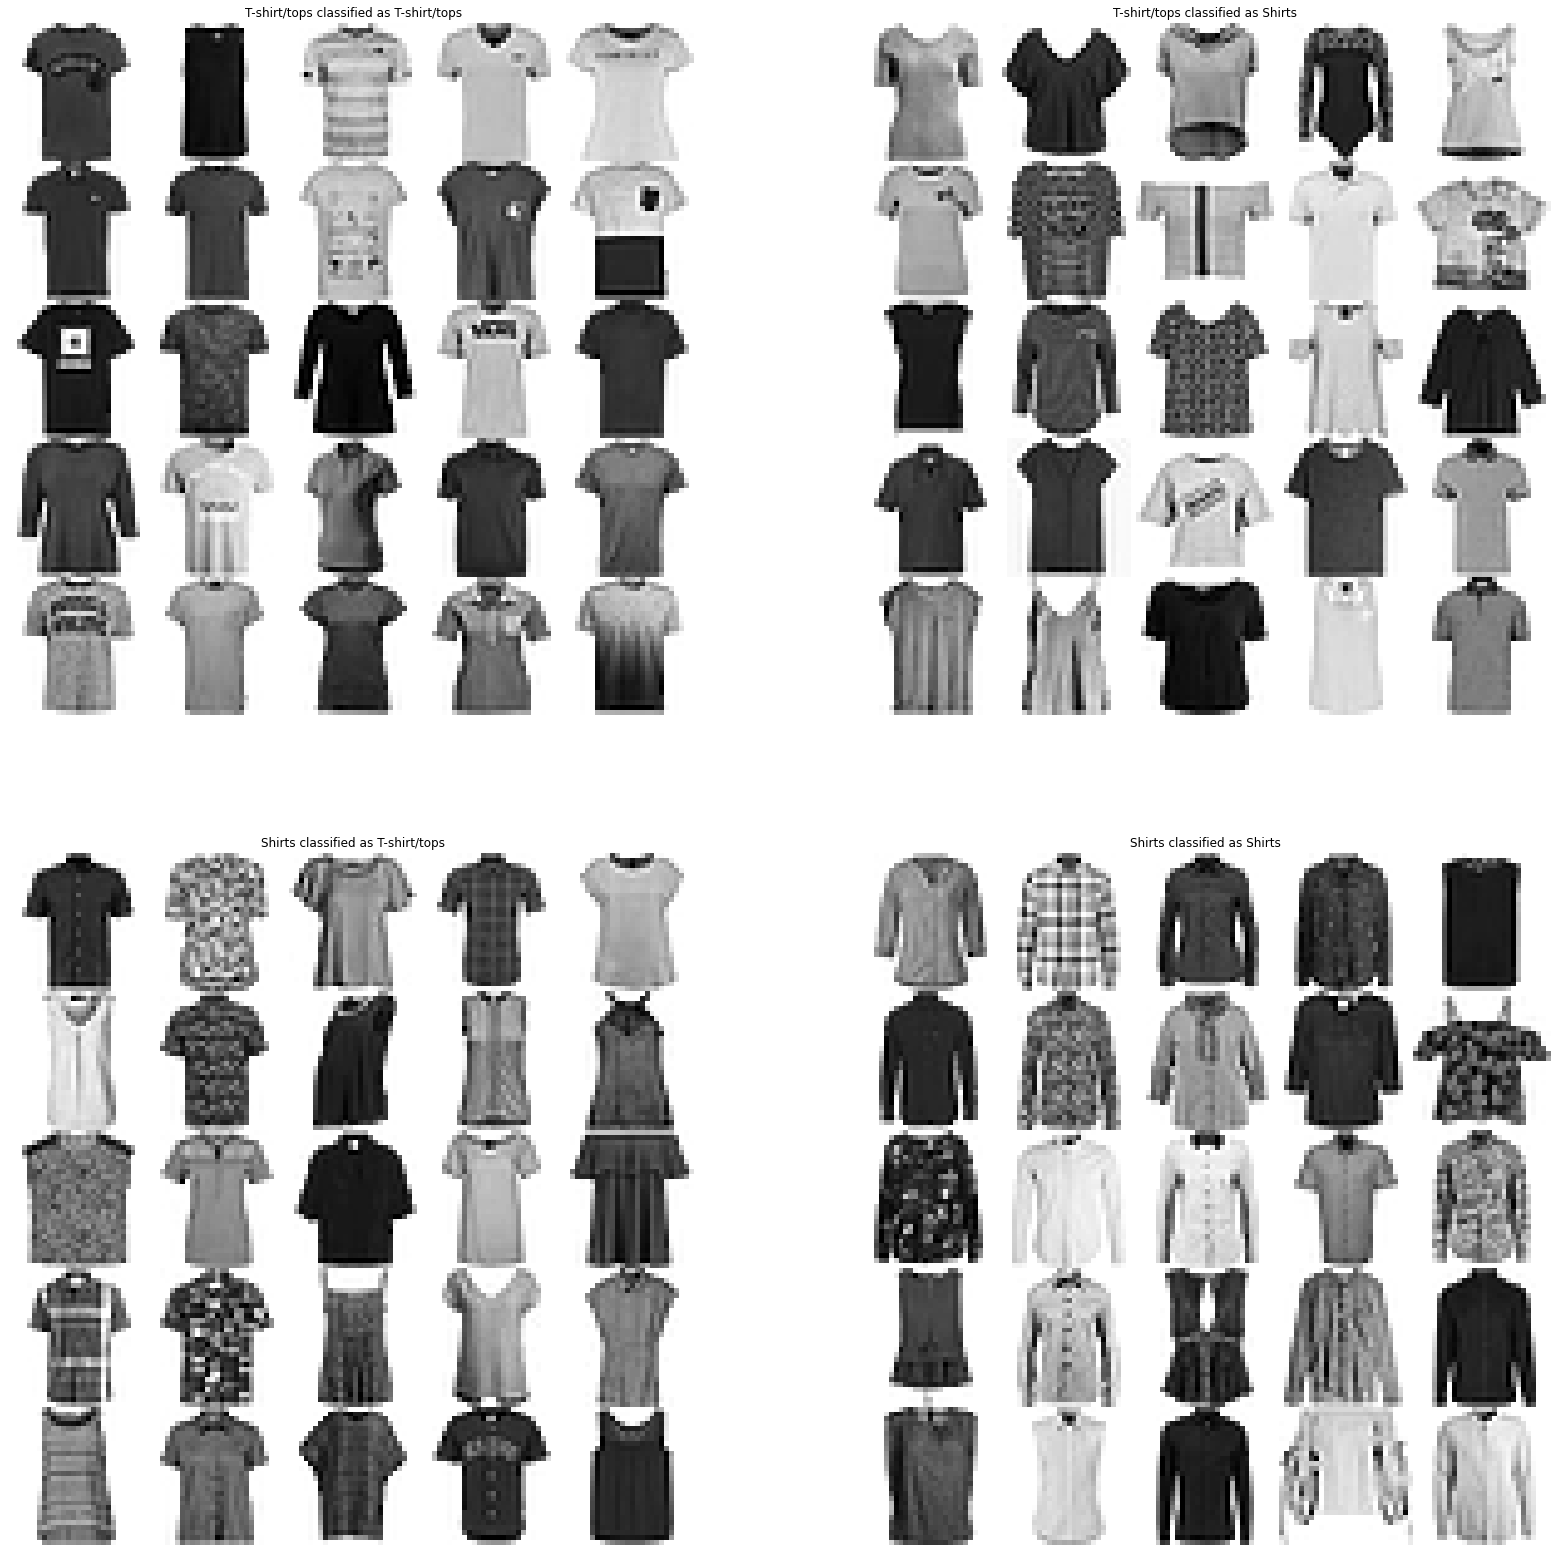

In [ ]:
plot_clothes(model, 0, 6)

The 20% dropout appears to have helped with the model's overfitting to some extent, but the model's accuracy still does not make it's way above the 90% threshold. Again, the model appears to have the most difficulty in classifying images in the 'Shirts' and 'T-shirt/tops' classes.

### DNN with 3 Layers and No Dropout

In [ ]:
model = tf.keras.Sequential([ 
                             tf.keras.Input(shape=(28,28,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256,activation = 'relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(64),
                             tf.keras.layers.Dense(10, activation='softmax')])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
98/98 [==============================] - 1s 5ms/step - loss: 0.9557 - accuracy: 0.6767 - val_loss: 0.43

313/313 [==============================] - 1s 2ms/step - loss: 0.3782 - accuracy: 0.8870
Test Set Accuracy: 88.7


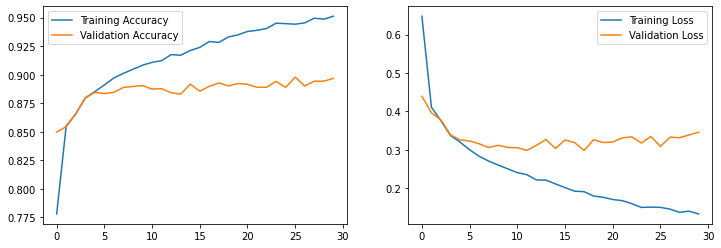

In [ ]:
evaluate_model(model, history, epochs)

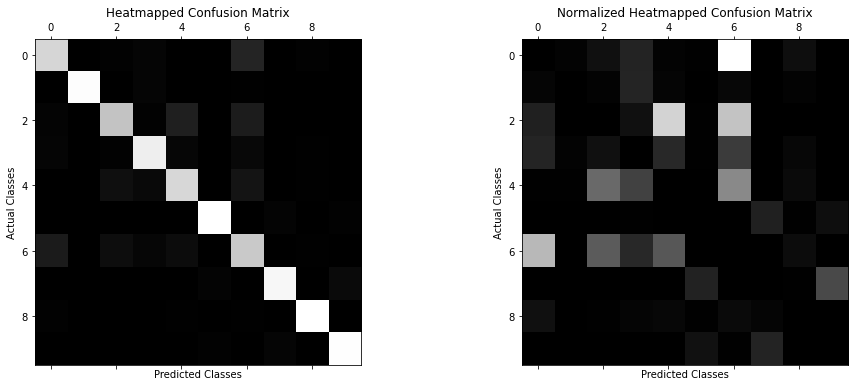

In [ ]:
heatmap_cm(model)

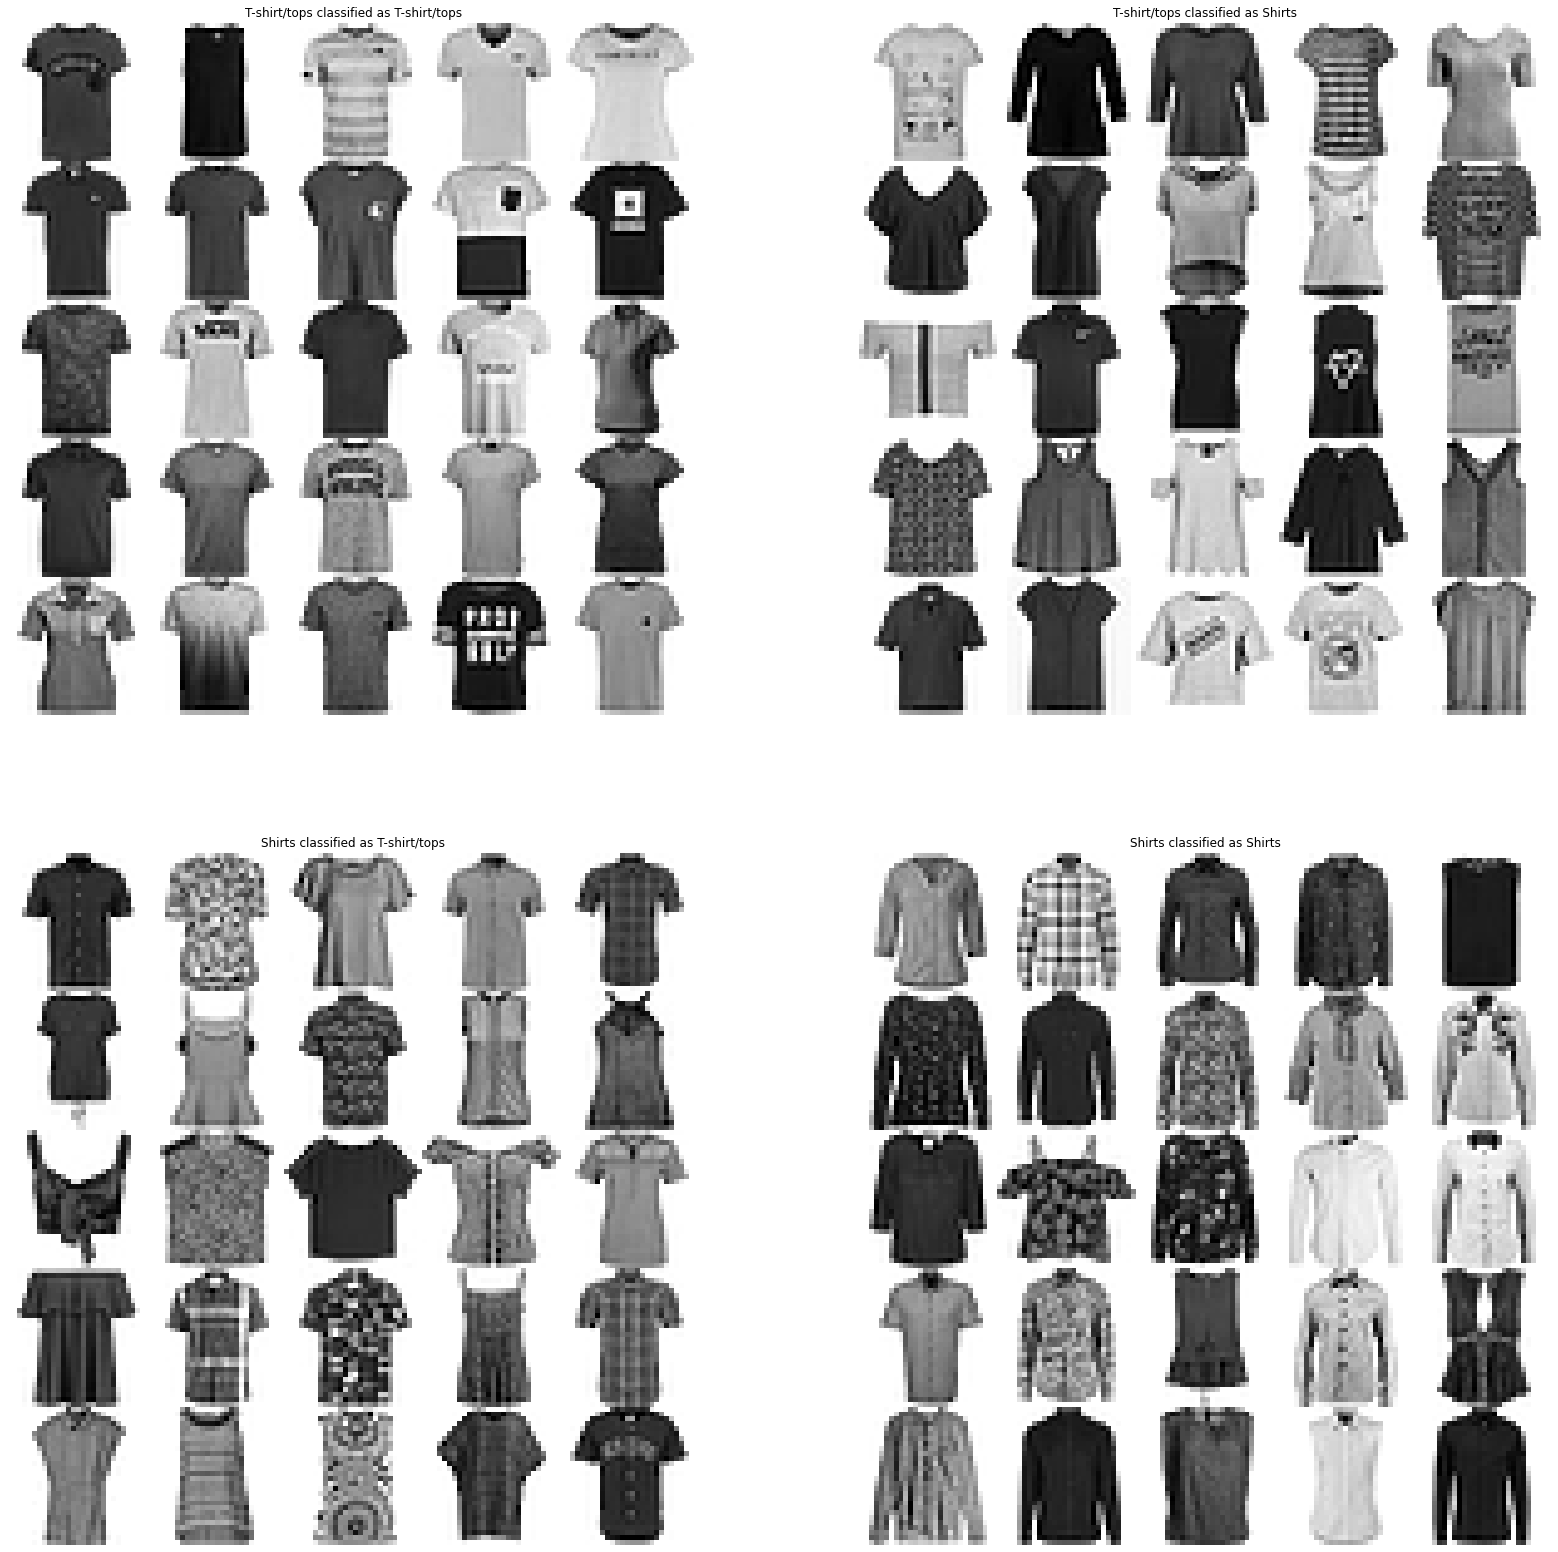

In [ ]:
plot_clothes(model, 0, 6)

The additional dense layer in this model does little to improve the model's accuracy as the same overfitting problem exists. So too does the 'Shirt' and 'T-shirt/tops' classification issue persist.  

### DNN with 3 Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([ 
                             tf.keras.Input(shape=(28,28,1)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256,activation = 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

313/313 [==============================] - 1s 2ms/step - loss: 0.3320 - accuracy: 0.8910
Test Set Accuracy: 89.1


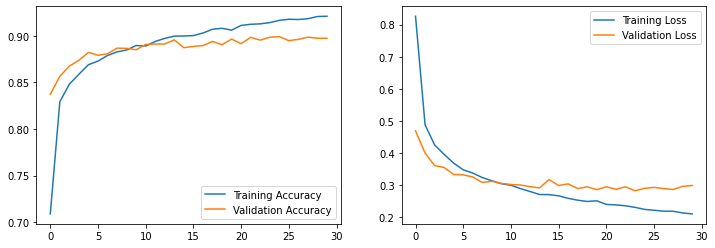

In [ ]:
evaluate_model(model, history, epochs)

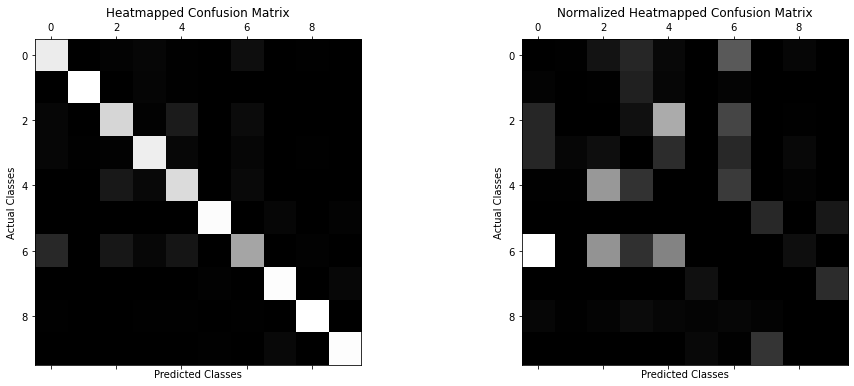

In [ ]:
heatmap_cm(model)

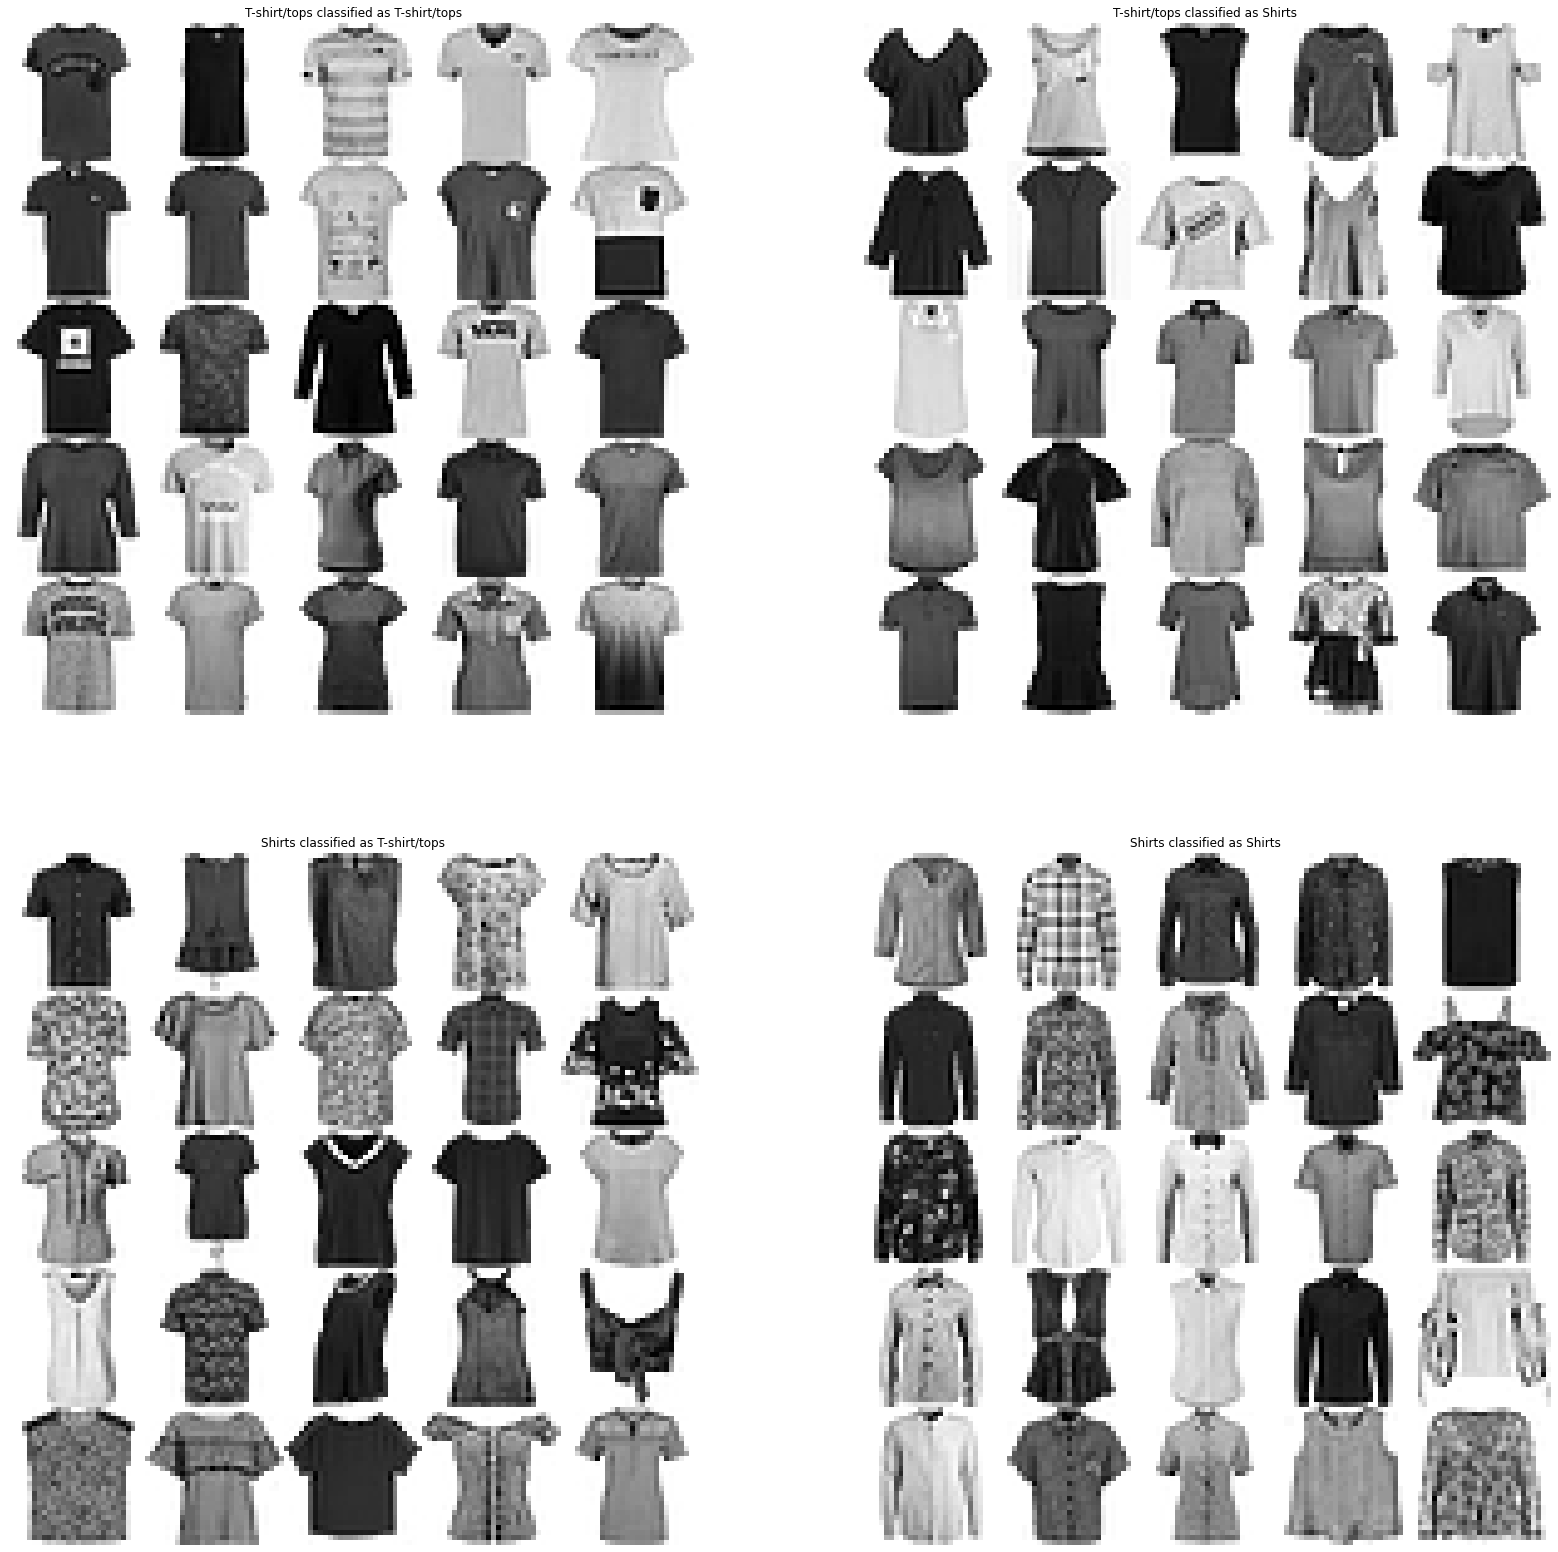

In [ ]:
plot_clothes(model, 0, 6)

The addition of dropout regularization has again combated the model's overfitting tendency, yet based on the validation accuracy, it can be concluded that the addition of a third dense layer does little in the way of increasing performance. The simpler, two-layer DNN with 20% dropout regularization is thus the preferred model in the DNN section and will serve as the performance baseline for the convolutional neural networks to come in the following section.

## Convolutional Neural Networks

### CNN with 2 Layers and No Dropout


In [ ]:
model = tf.keras.Sequential([
                             
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1639424   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

313/313 [==============================] - 1s 2ms/step - loss: 0.4732 - accuracy: 0.9099
Test Set Accuracy: 90.99


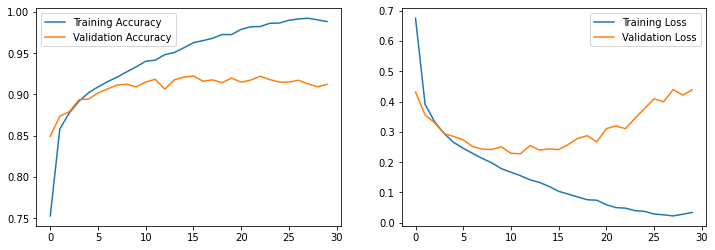

In [ ]:
evaluate_model(model, history, epochs)

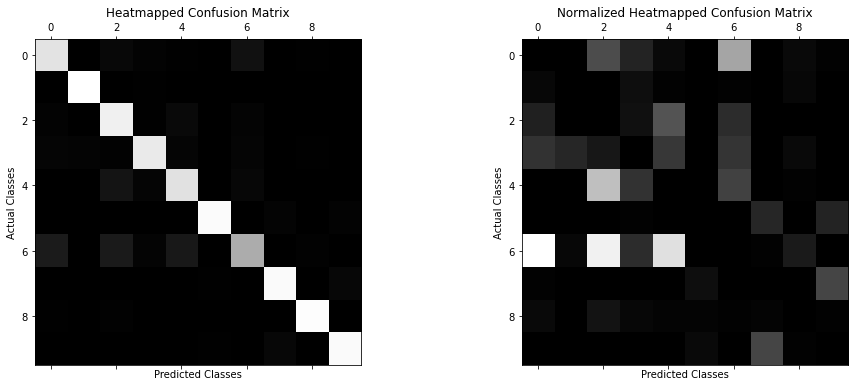

In [ ]:
heatmap_cm(model)

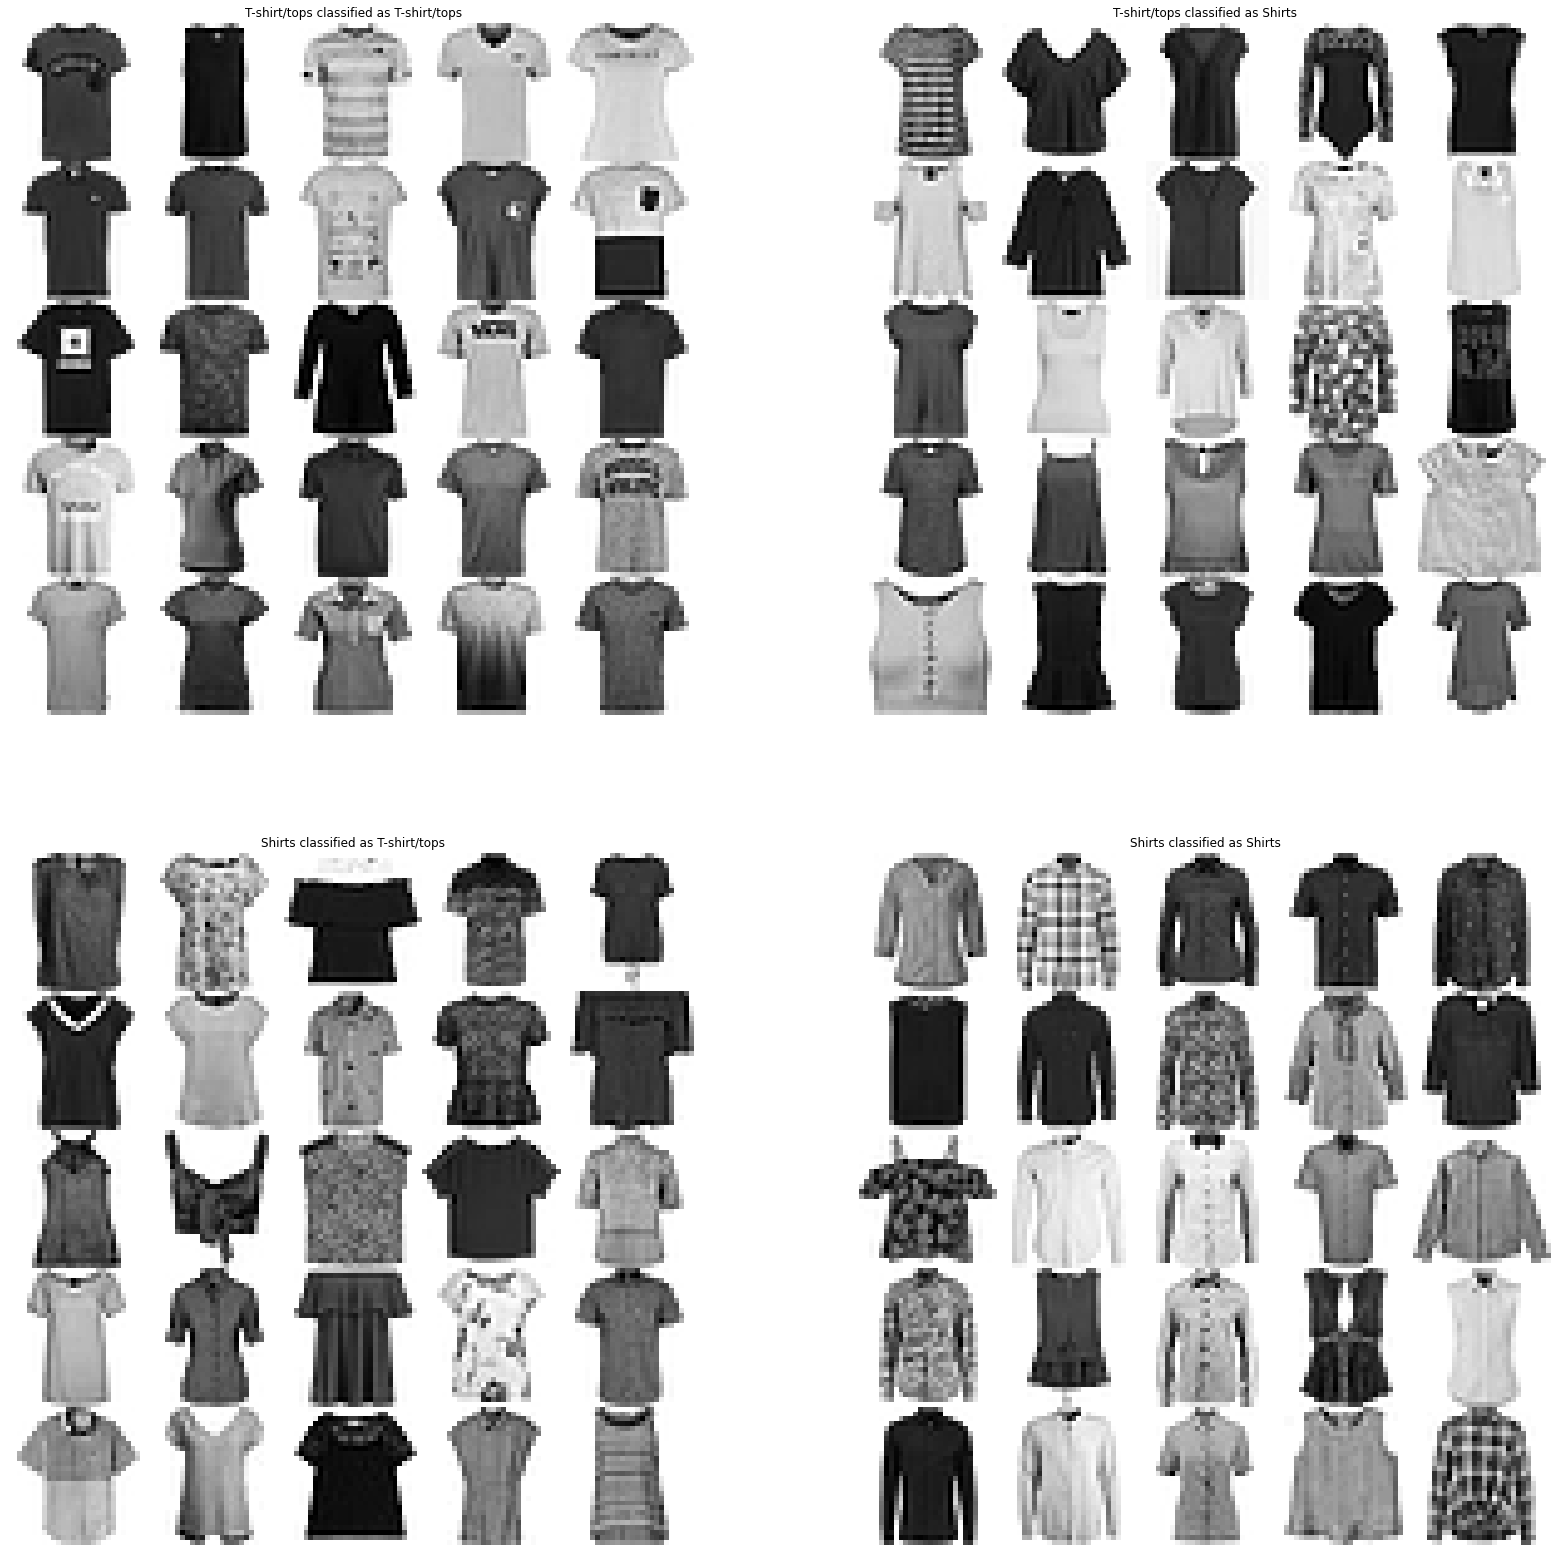

In [ ]:
plot_clothes(model, 0, 6)

The addition of convolutional layers has increased the predictive power of the model considerably, and the test accuracy now rests a few points above the 90% threshold. That being said, the overfitting demonstrated here is even more substantial than the overfitting present in any of the DNN's. The 'Shirt' and 'T-shirt/tops' problem has not gone away, either.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


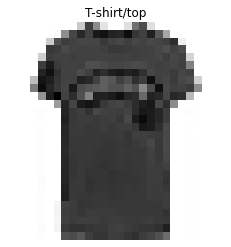

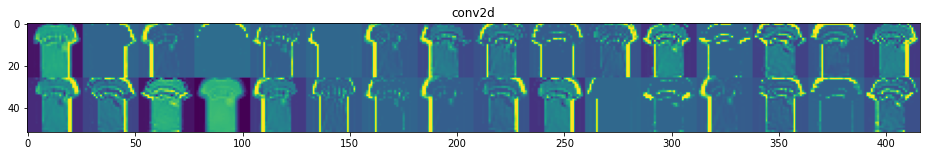

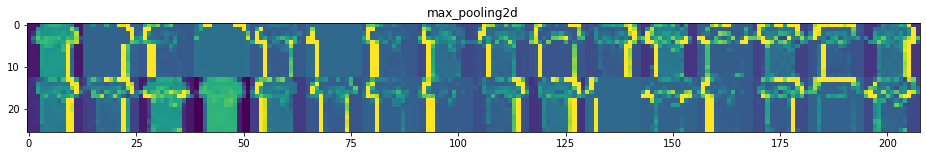

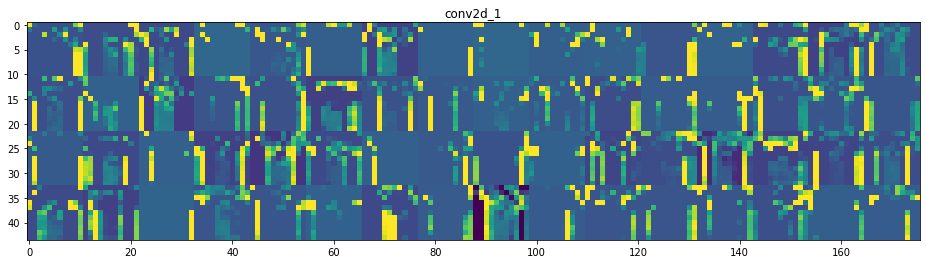

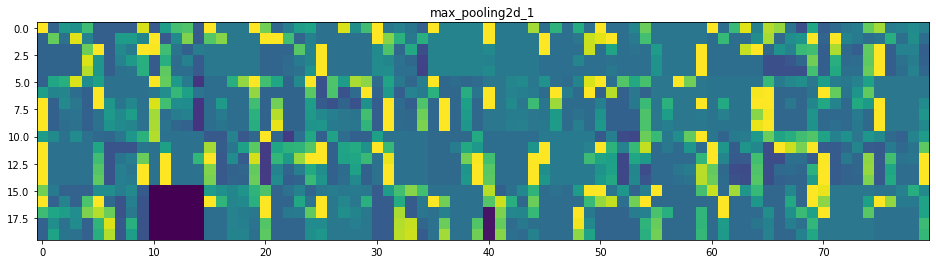

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


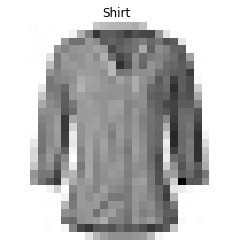

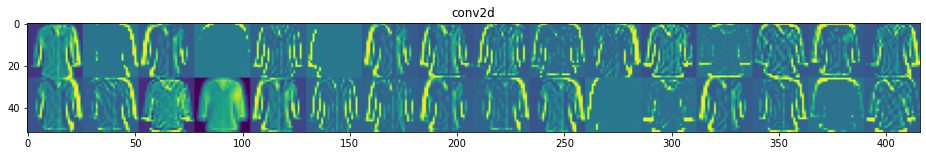

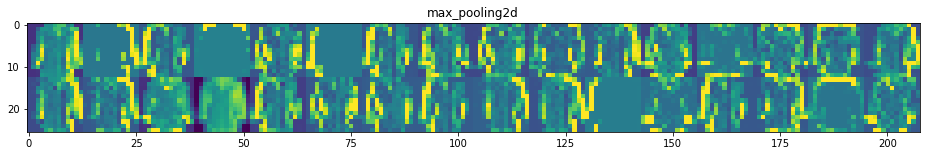

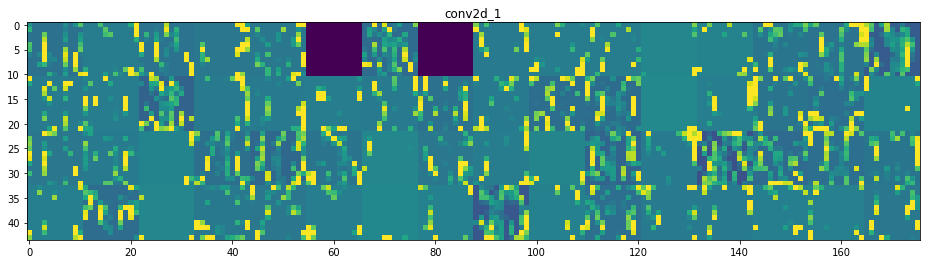

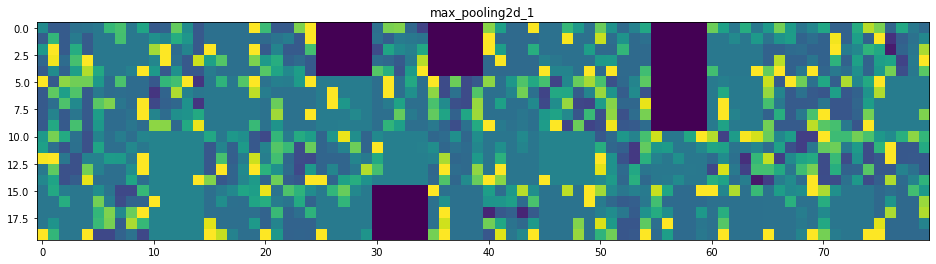

In [ ]:
conv_layer_plots(model, 6)

These two plots are of the convolutional layers' activation values; the first is of those activations associated with the prediction of the grayscale 'T-shirt/top' image, and the second is of those activations associated with the prediction of the grayscale 'Shirt' image. An interesting takeaway from these two groups of plots is the disparity in the degree of detail between the two 'conv2d' plots. For the 'T-shirt/top' image, there is not a tremendous amount of definition, especially when it comes to the torso area of the piece of clothing. As for the 'Shirt' image, there is far more detail in the torso area, which is likely the result of the greater variability in the pixel values in that location.

Another noteworthy difference is the horizontal locations of the largest activation values. For the 'T-shirt/top' image, these locations are just to the left and the right of the center of the image, outlining the sides of the article of clothing. For the 'Shirt' image, these locations are far closer to the edges of the image, indicating the presence of sleeves. To some extent, this confirms the idea that the 'T-shirt/top' and 'Shirt' distinction is based primarily upon the presence or absence of sleeves.

### CNN with 2 Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

313/313 [==============================] - 1s 2ms/step - loss: 0.2681 - accuracy: 0.9176
Test Set Accuracy: 91.76


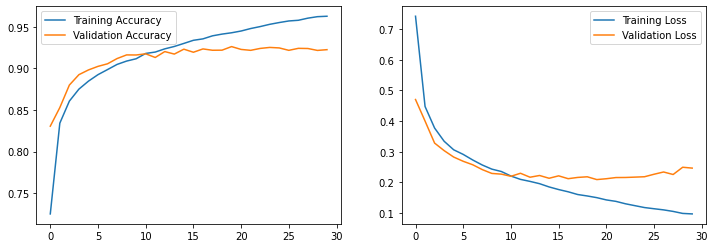

In [ ]:
evaluate_model(model, history, epochs)

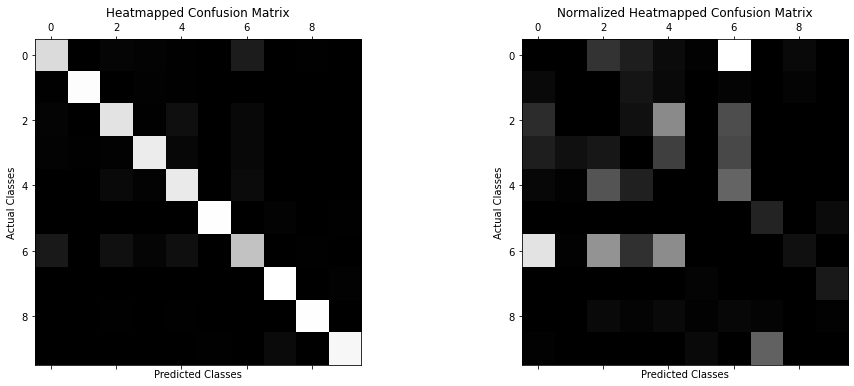

In [ ]:
heatmap_cm(model)

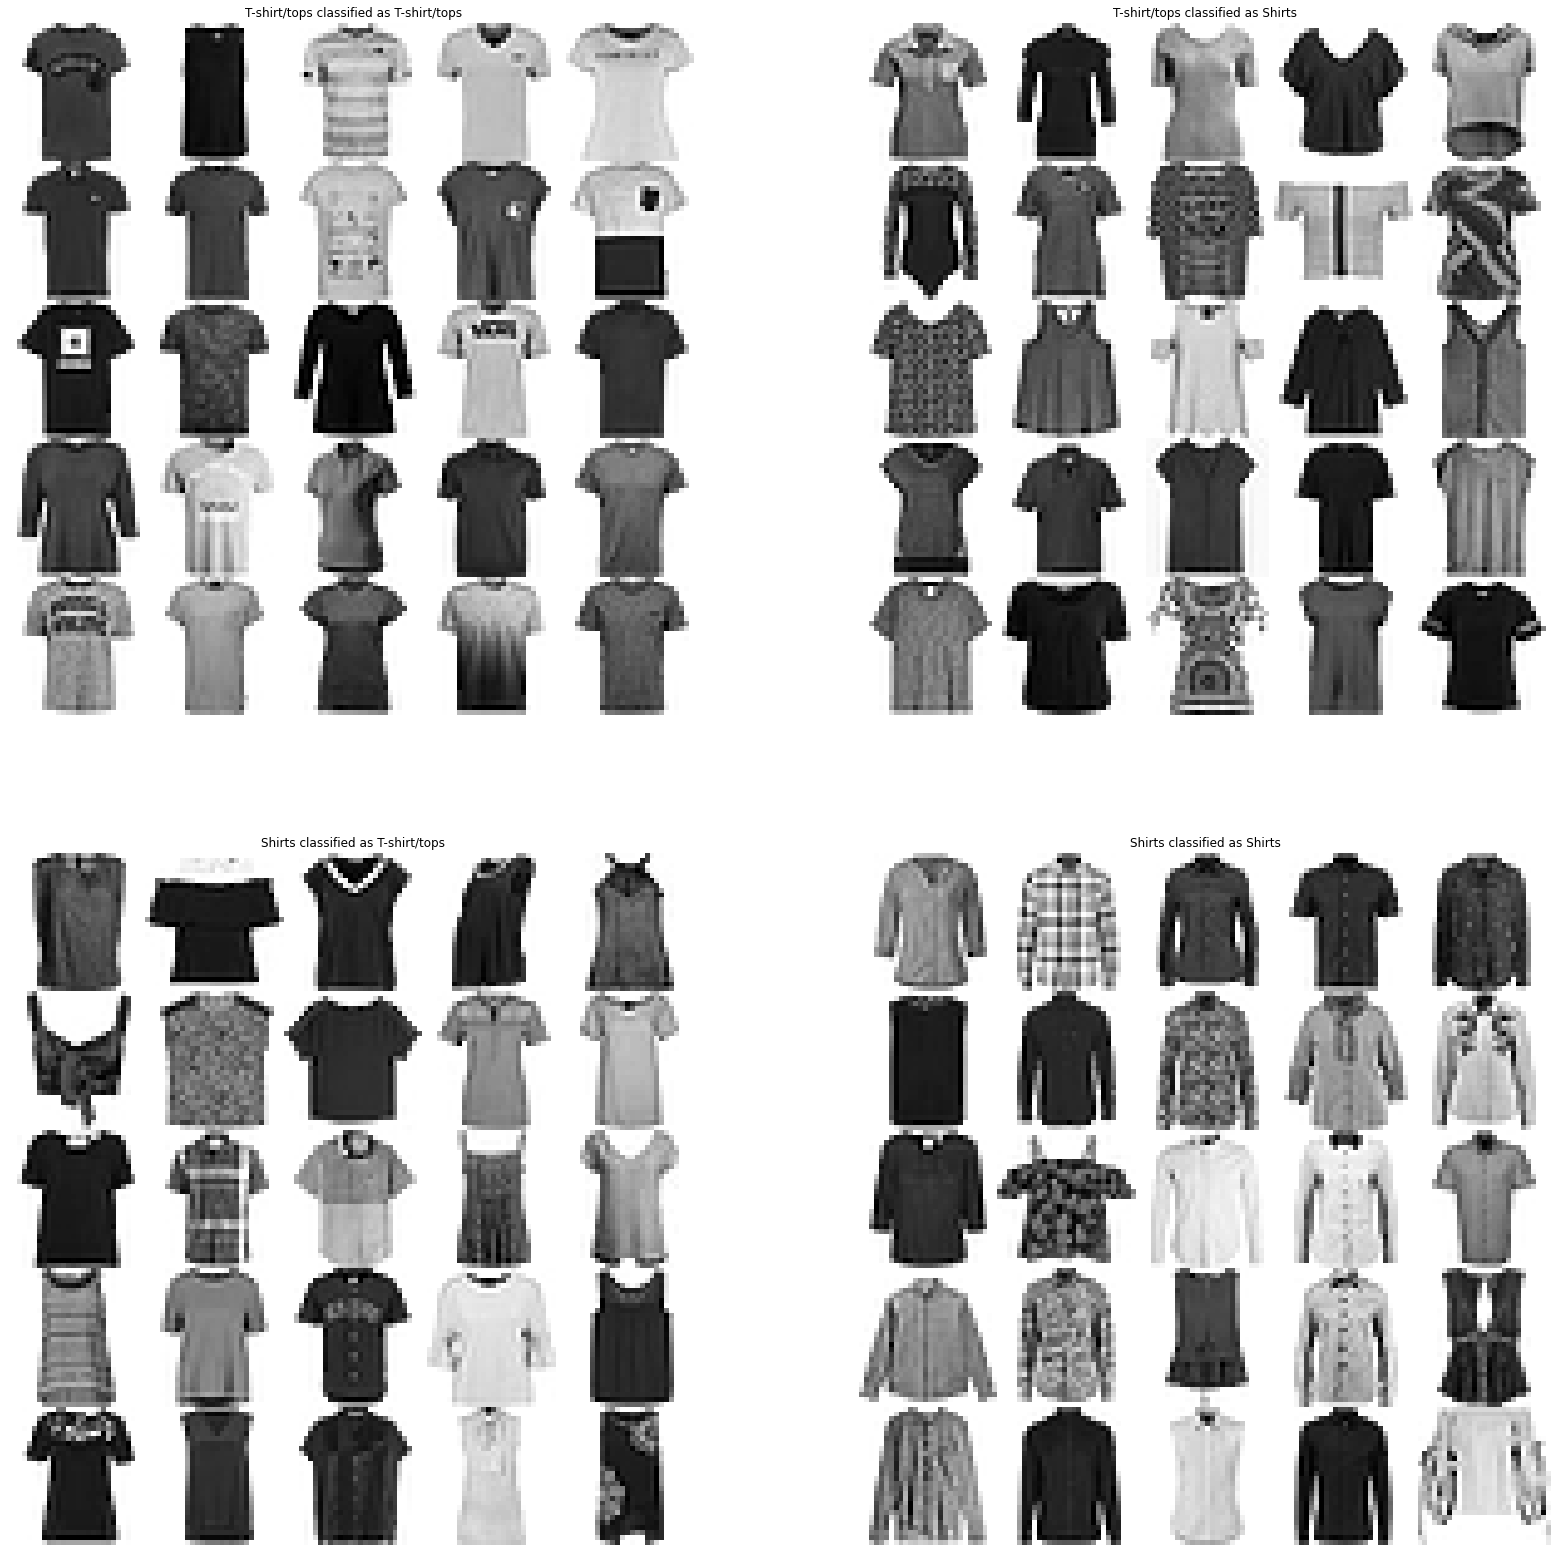

In [ ]:
plot_clothes(model, 0, 6)

The inclusion of dropout here delays the model's overfitting substantially until after the 15th epoch, as opposed to the previous model that started to overfit following the 5th epoch. This delay does not do a great deal in terms of testing accuracy, though, only providing about a 0.5% performance increase. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


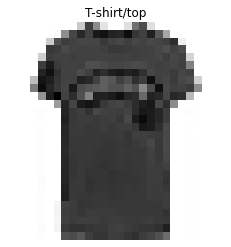

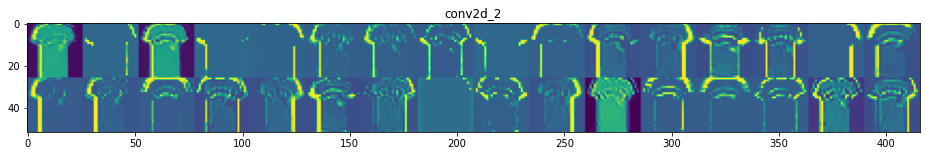

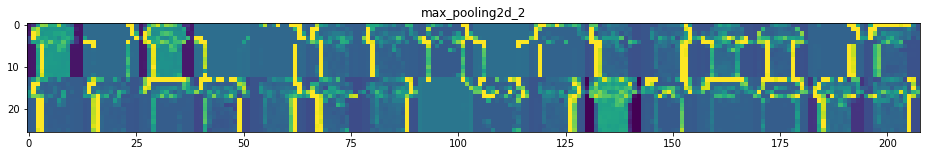

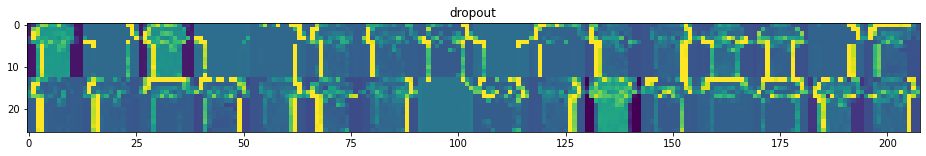

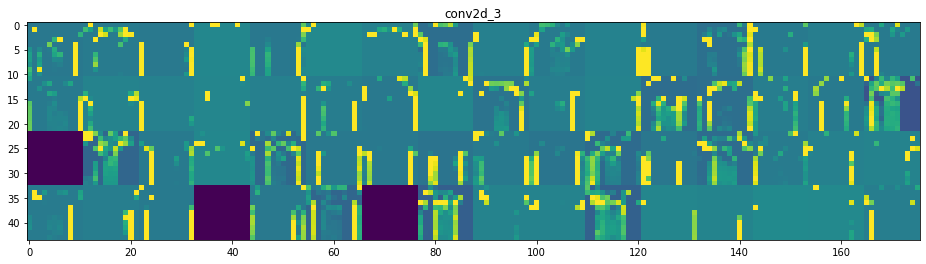

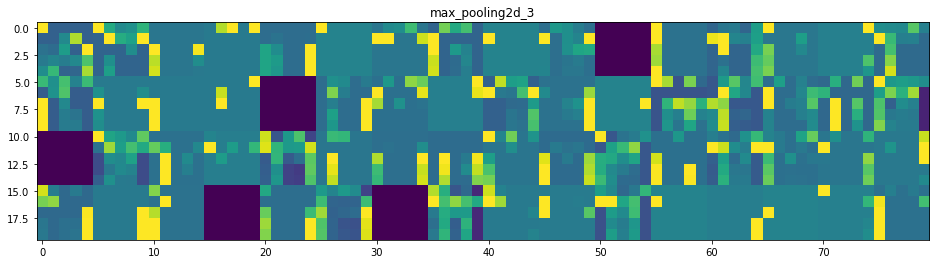

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


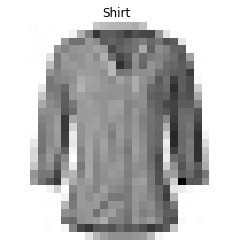

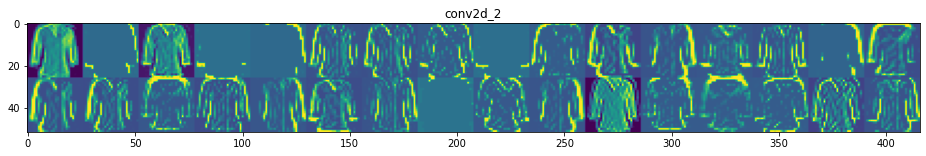

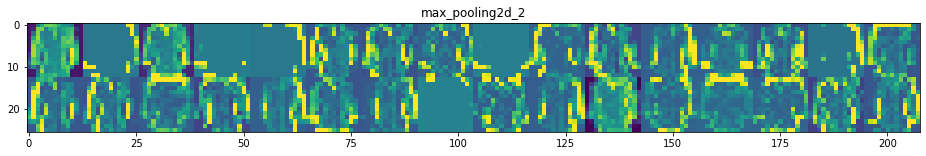

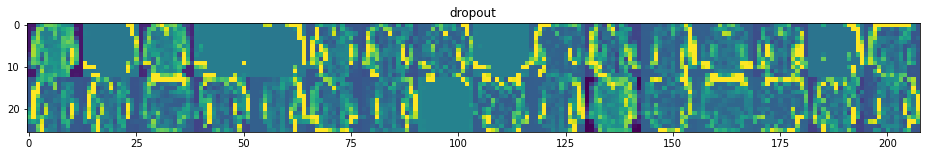

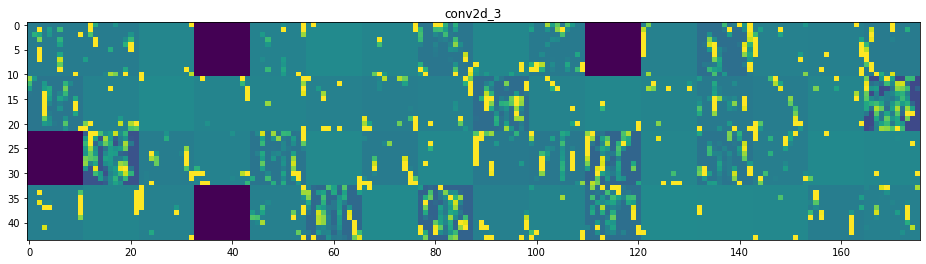

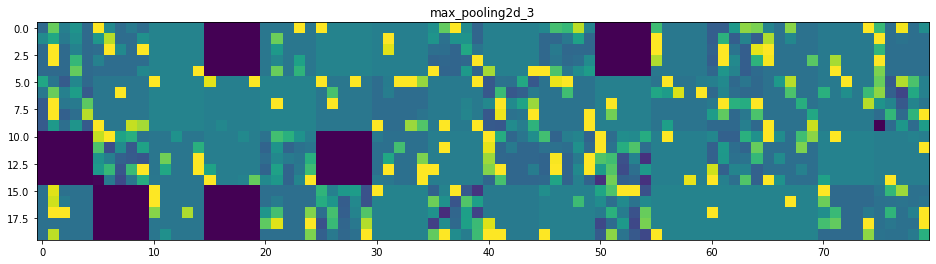

In [ ]:
conv_layer_plots(model, 6)

The presence of dropout appears to have tamped down the extent to which the model learns what is within the bounds of the article of clothing, i.e. the chest and torso areas. The level of detail that was present in the unregularized version of is not so extreme now. Instead, the higher activation values seem to be located mostly on the areas that form the outline of the article of clothing in the image. 

### CNN with 3 Layers and No Dropout

In [ ]:
model = tf.keras.Sequential([         
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

313/313 [==============================] - 1s 2ms/step - loss: 0.4534 - accuracy: 0.8844
Test Set Accuracy: 88.44


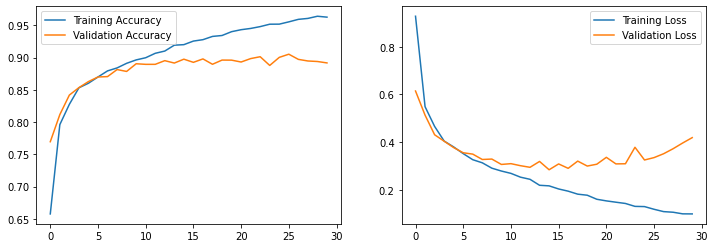

In [ ]:
evaluate_model(model, history, epochs)

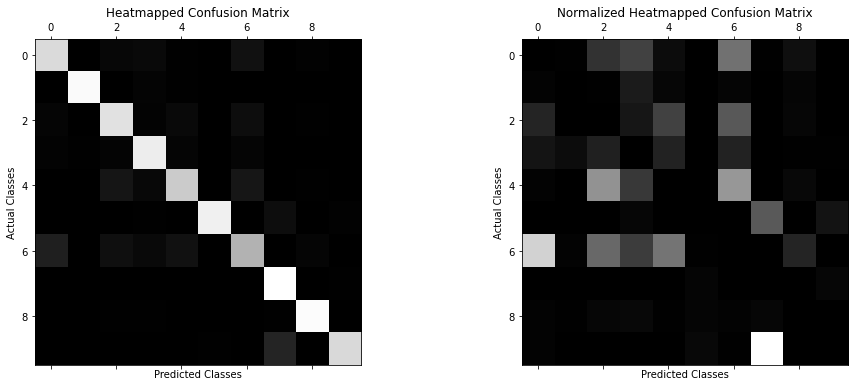

In [ ]:
heatmap_cm(model)

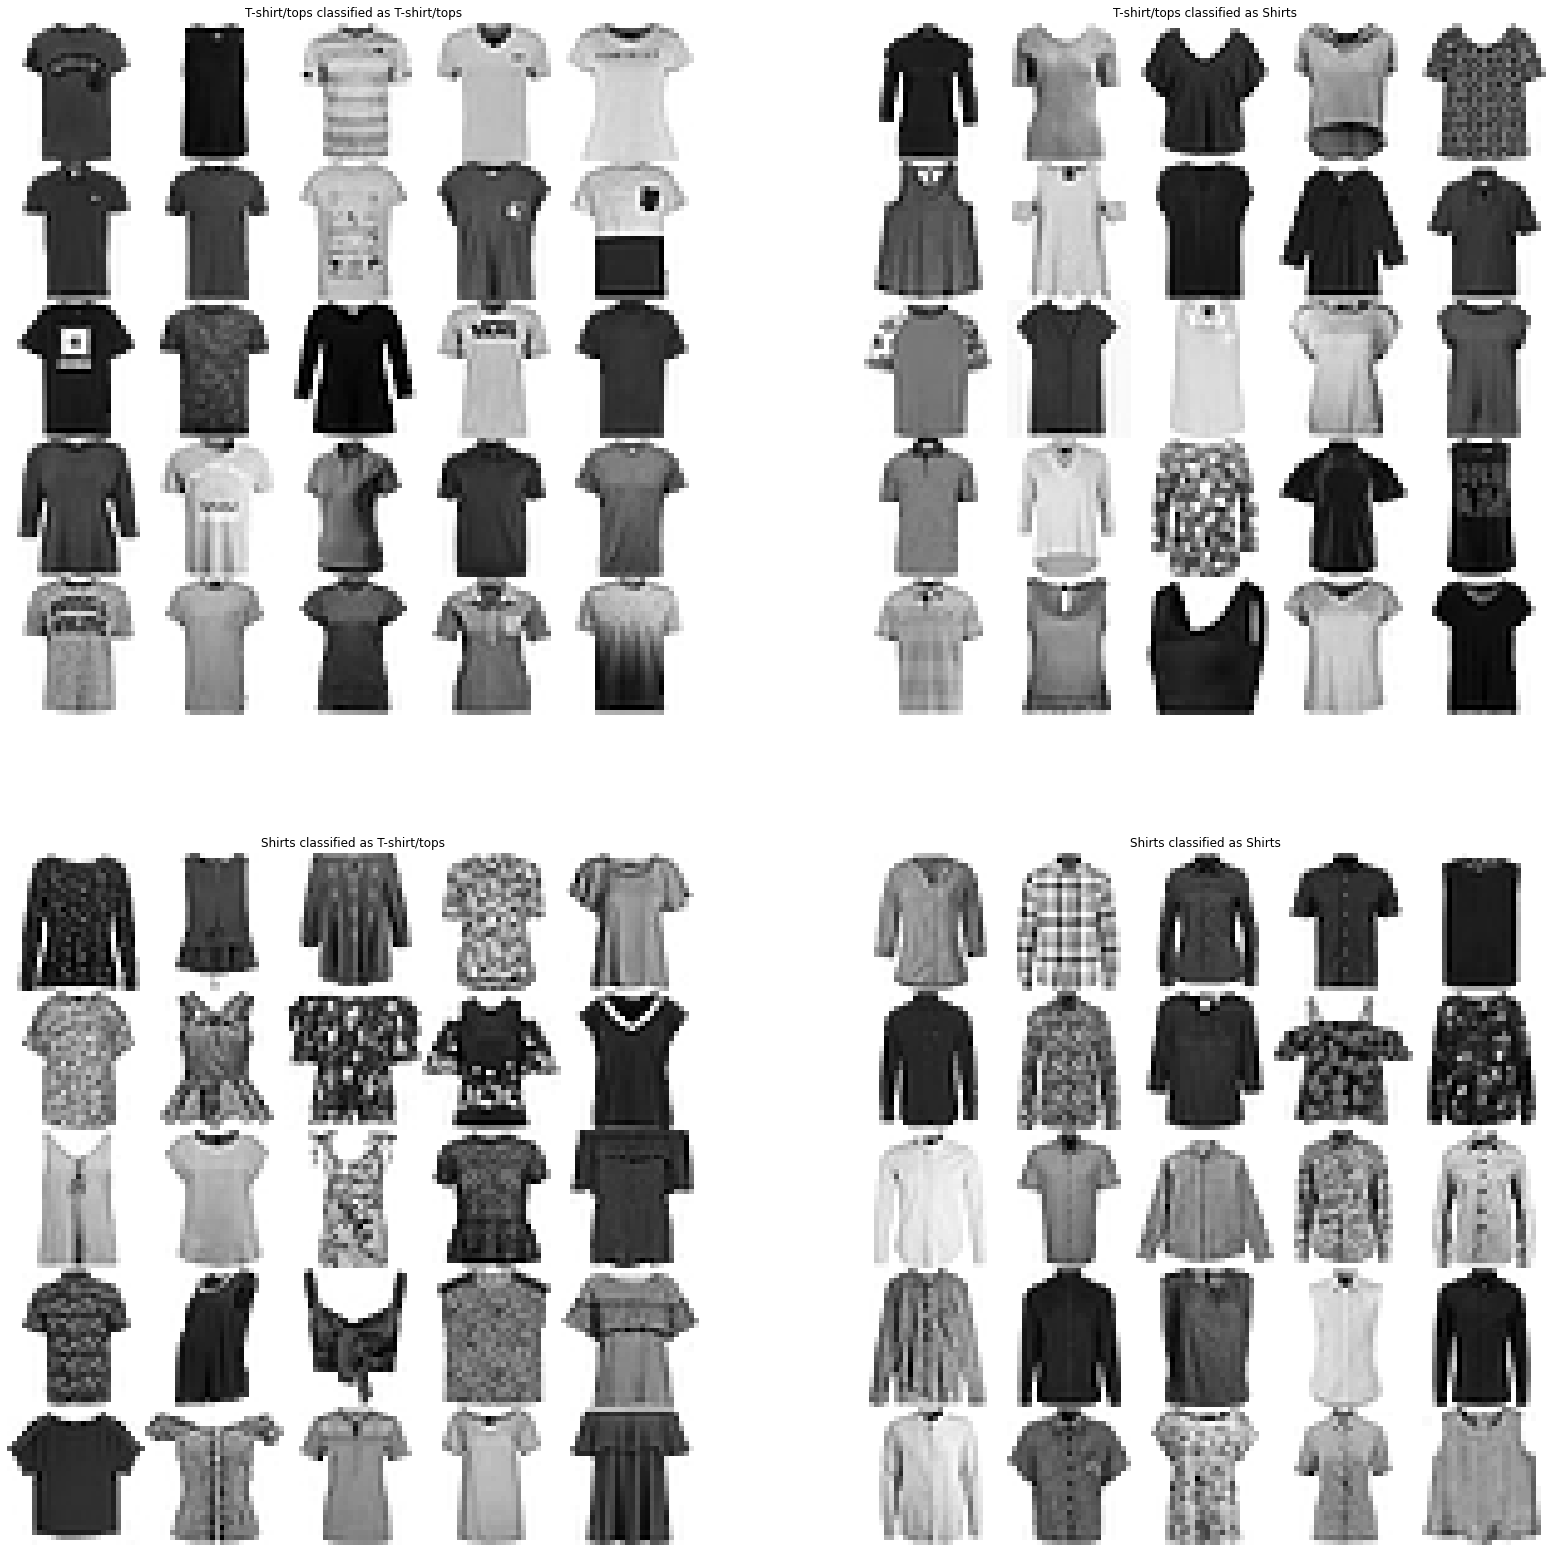

In [ ]:
plot_clothes(model, 0, 6)

While the addition of a third convolutional layer leaves the model's performance on the training set comparable to that of the previous two models, the extra capacity appears to lead to more substantial overfitting. While the previous models demonstrated testing accuracies above 90%, this model's test set accuracy dips back below 90%. That coupled with the lack of any obvious improvement in training set performance would lead one to believe that the addition of a third layer has little positive impact on the model's quality, much in the same way that a third dense layer did not improve performance in the DNN models. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


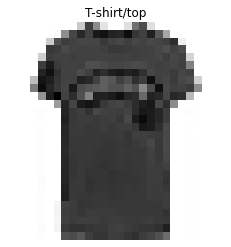

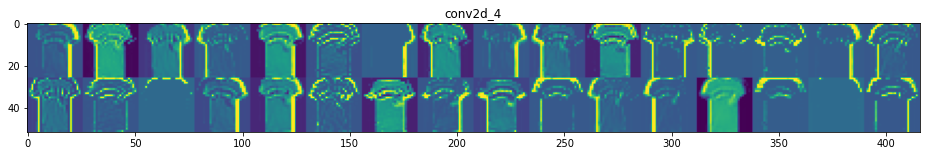

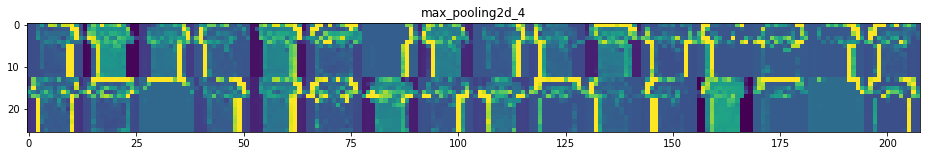

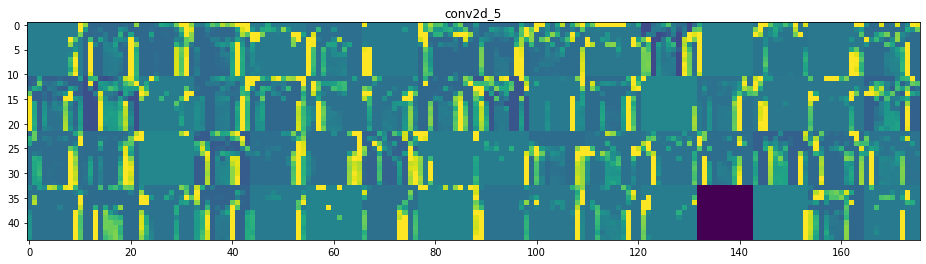

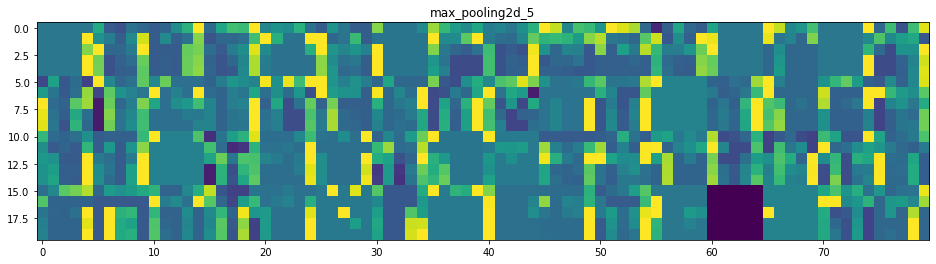

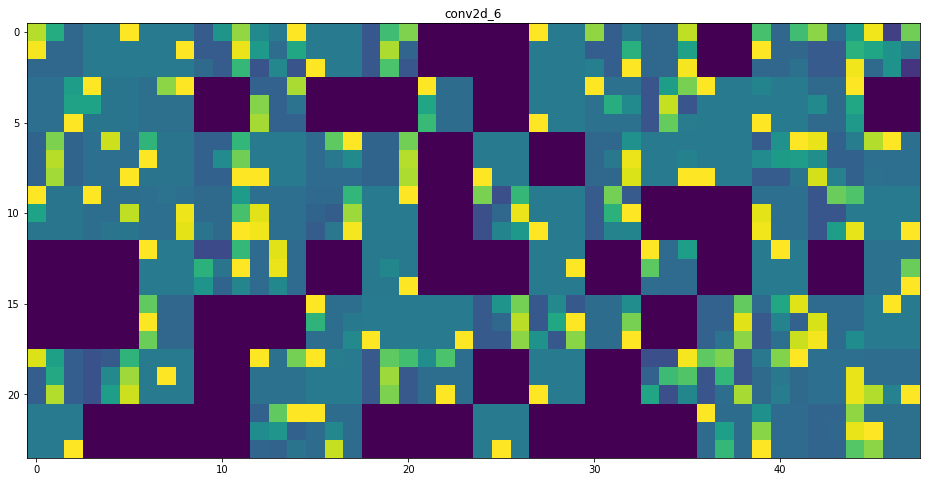

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


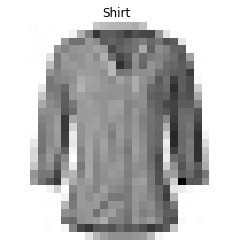

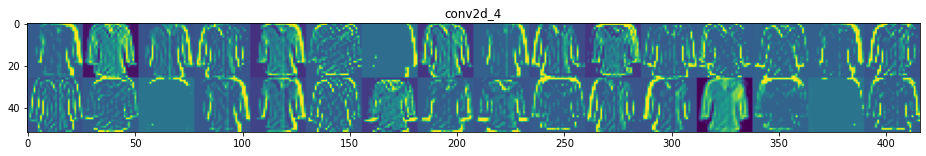

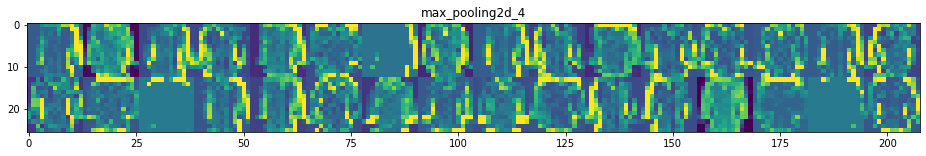

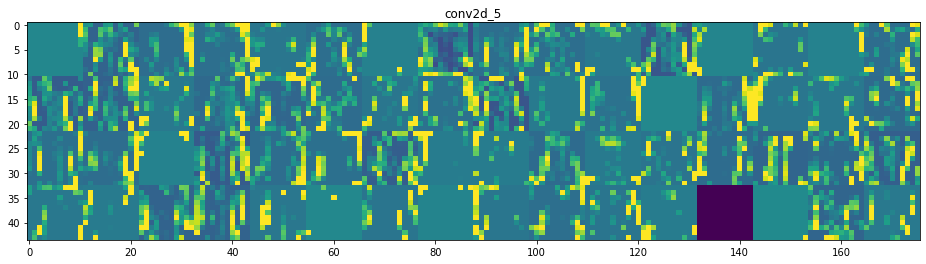

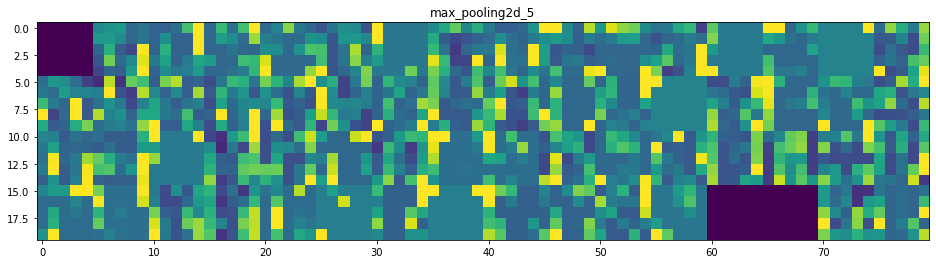

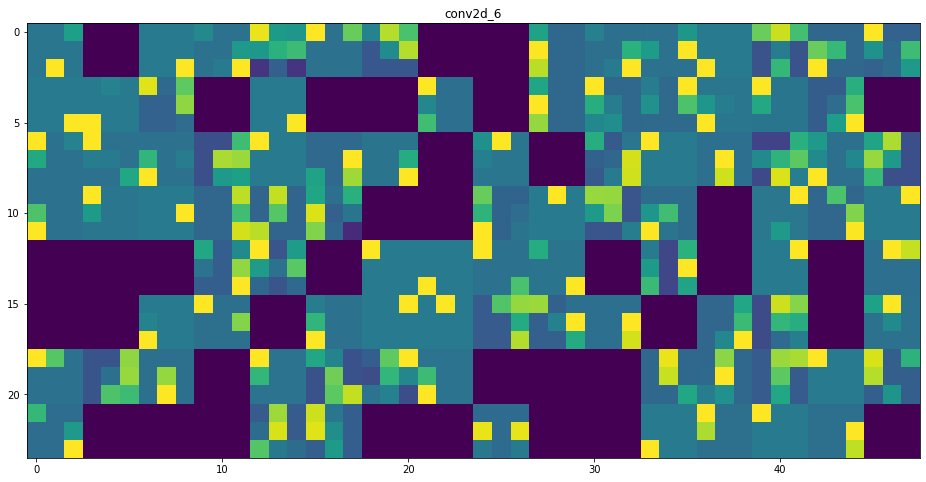

In [ ]:
conv_layer_plots(model, 6)

Without the dropout regularization and with the additional layer, the level of detail learned by the model is far greater than it was in the previous two models. This level of detail has been shown to be unnecessary, though, given the poorer generalization quality.

### CNN with 3 Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)        

313/313 [==============================] - 1s 2ms/step - loss: 0.2825 - accuracy: 0.8969
Test Set Accuracy: 89.69


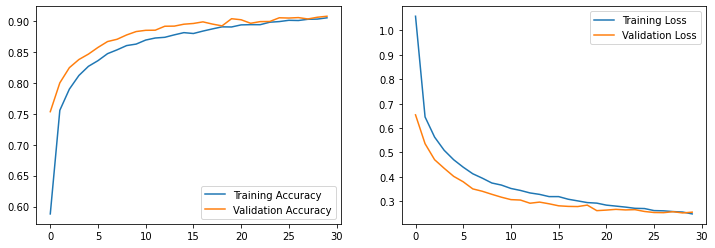

In [ ]:
evaluate_model(model, history, epochs)

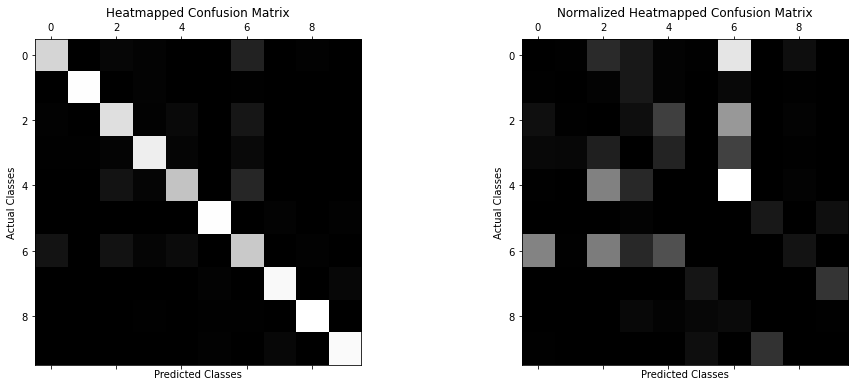

In [ ]:
heatmap_cm(model)

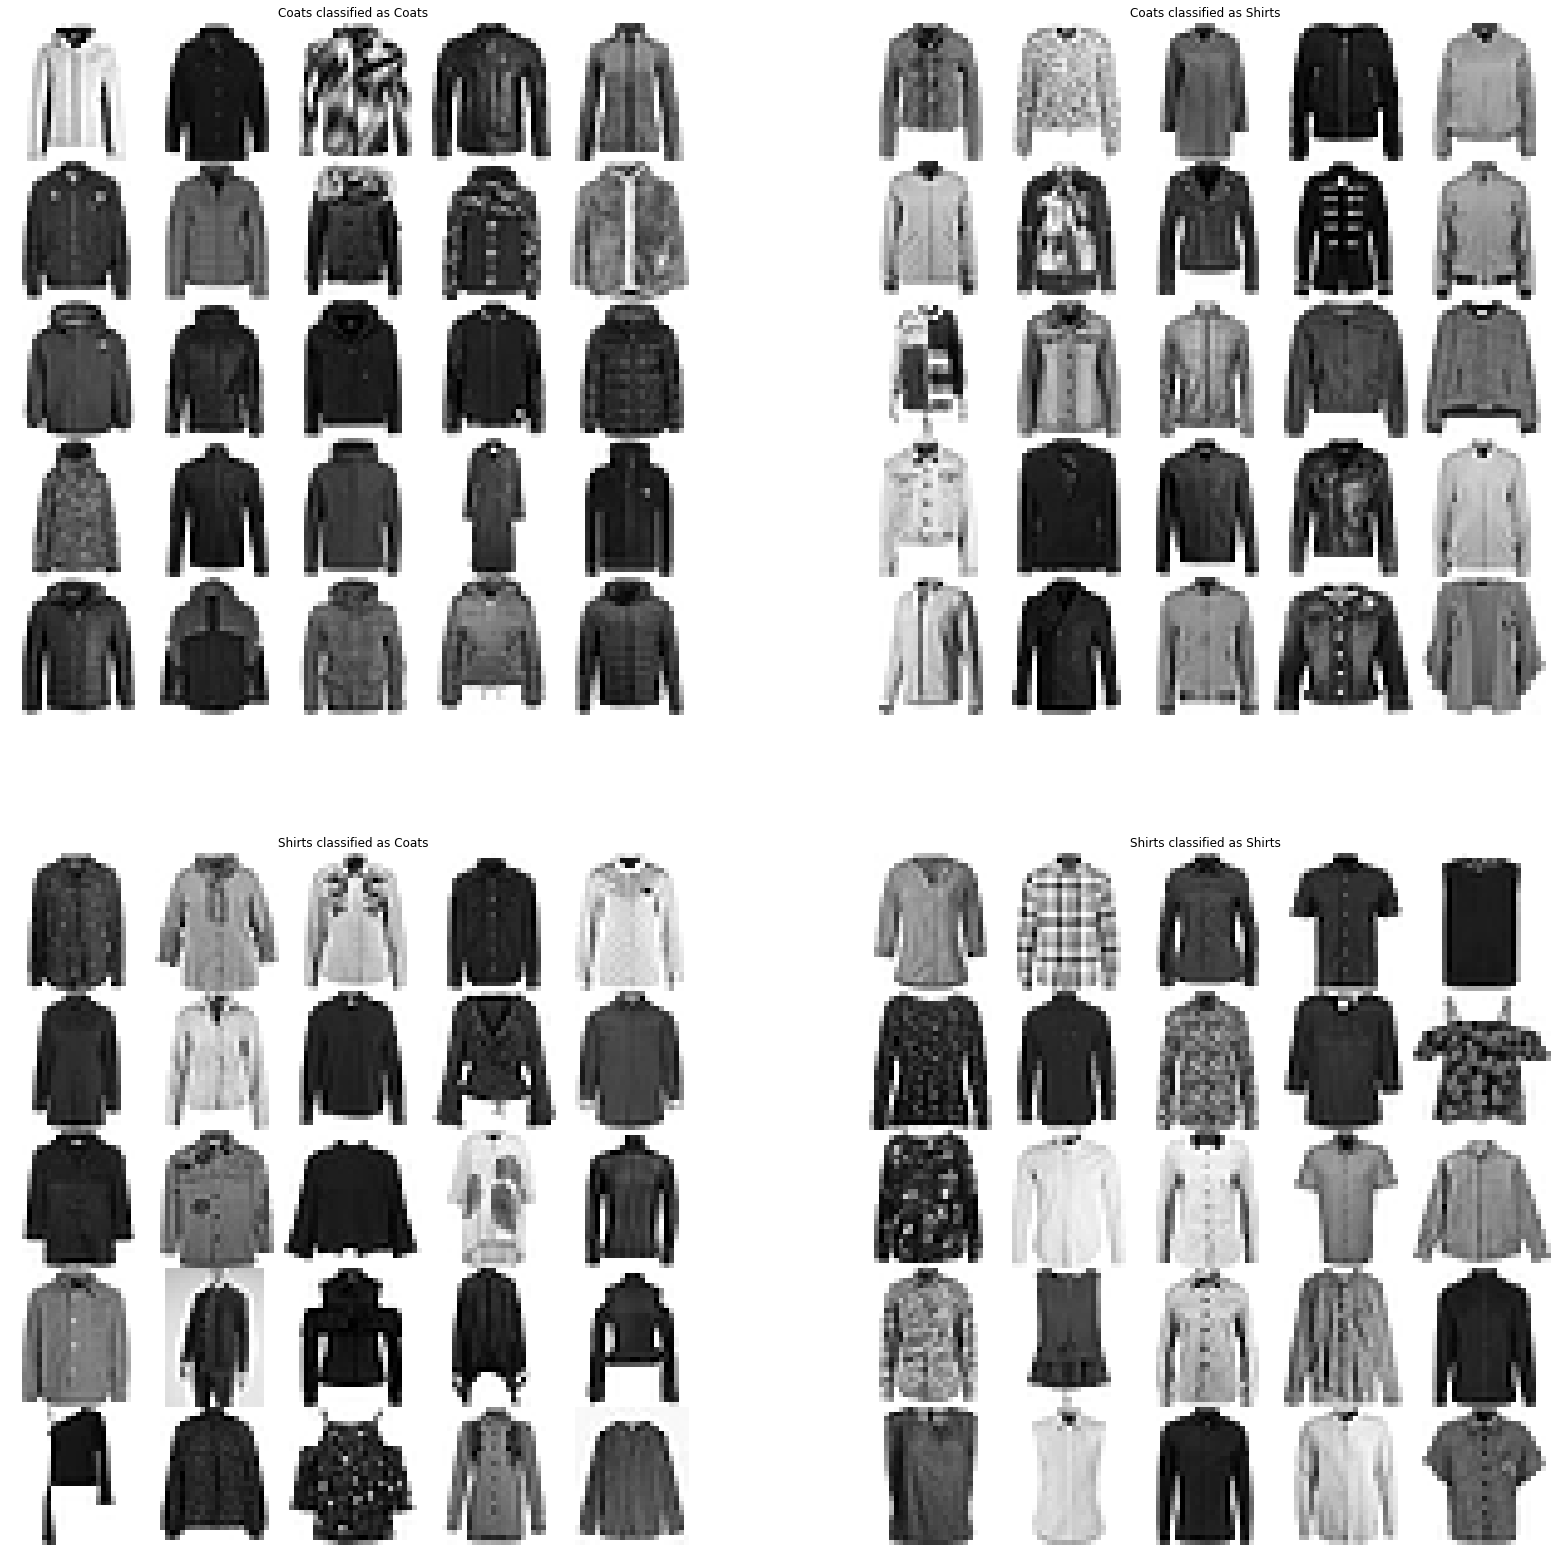

In [ ]:
plot_clothes(model, 4, 6)

This seems to be the first model that doesn't demonstrate any substantial overfitting. The training and validation accuracies and losses are in lockstep throughout the training process, although the testing accuracy does dip back below 90%. An interesting quality of this model is the point of differentiation with which is struggles. Rather than continuing the trend from the previous several models, this model struggles most with understanding the difference between the 'Shirts' and 'Coats' classes. This difficulty appears to stem from the general, structural similarities in coats and long-sleeved shirts. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


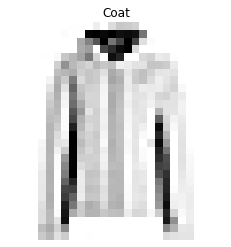

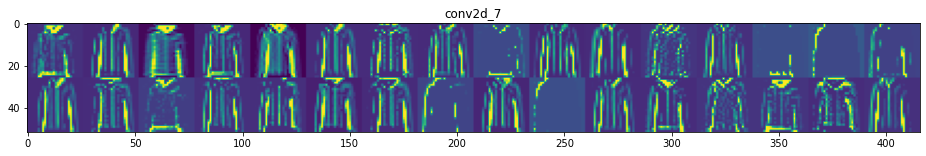

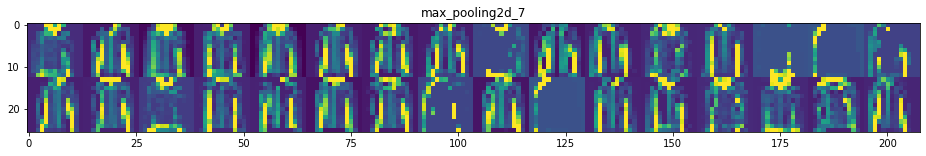

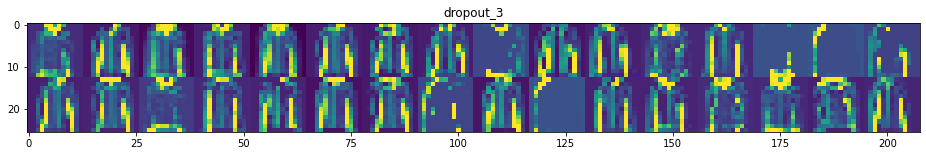

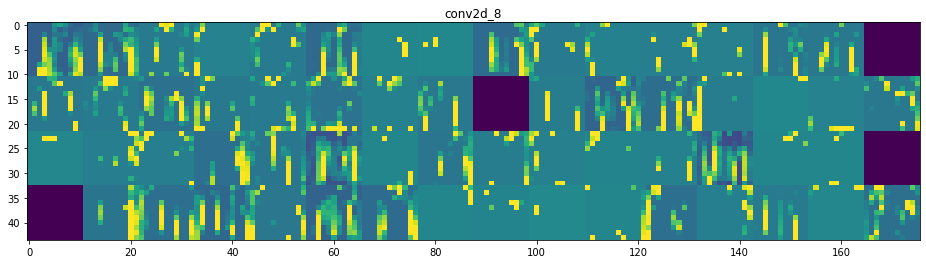

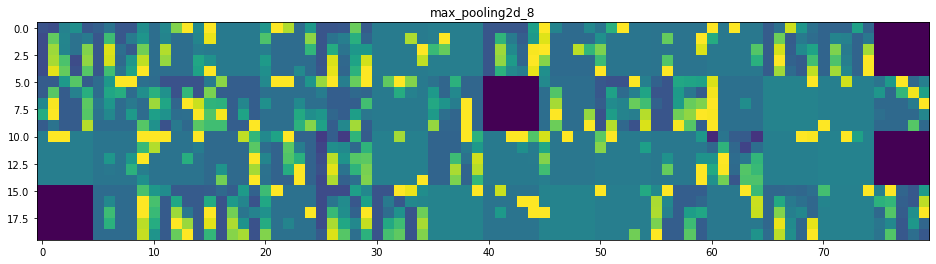

In [ ]:
conv_layer_plots(model, 4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


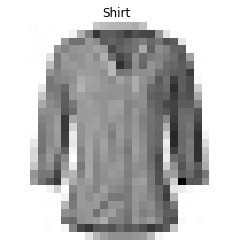

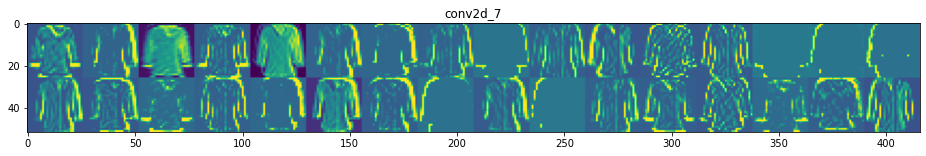

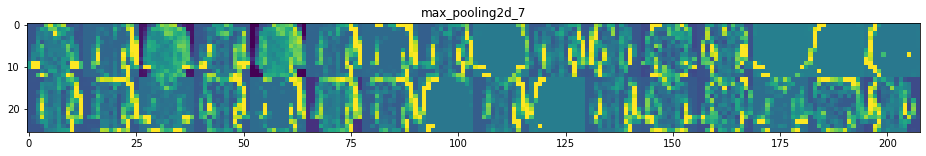

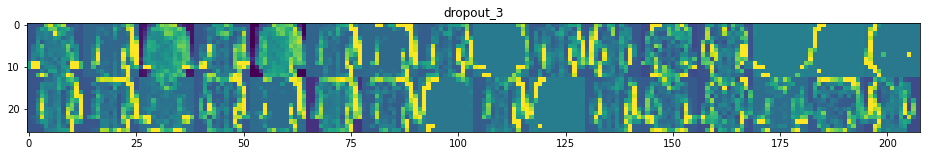

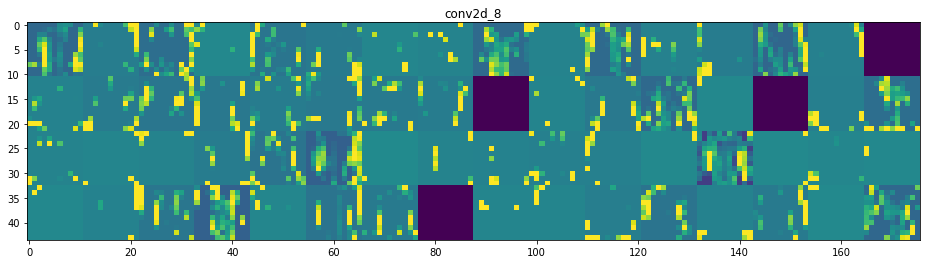

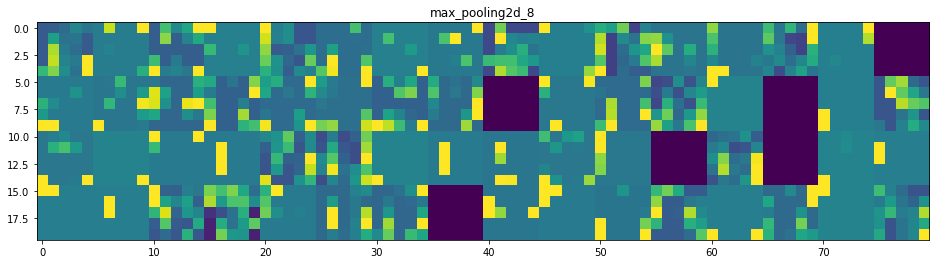

In [ ]:
conv_layer_plots(model, 6)

What is a bit surprising about these two sets of plots is the difference in generalizability suggested by the first plot in each set. The top 'Shirt' plot has plenty of green coloring, suggesting that there is not all that much of a noticeable difference between the outline of the shirt and the rest of the image. The top 'Coat' plot, on the other hand, has an incredibly well-defined outline. In the preceding normalized heatampped confusion matrix, a high number of images in the 'Coat' class were misclassified into the 'Shirt' class - it appears that the model had a very specific idea of what constitutes a coat, and if a particular 'Coat' image did not fit that idea, it was incorrectly classified as a 'Shirt'.

### CNN with 2 Blocks of 2 Convolutional Layers and No Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)             

313/313 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.9133
Test Set Accuracy: 91.33


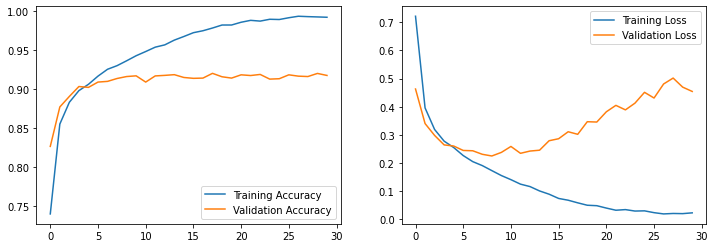

In [ ]:
evaluate_model(model, history, epochs)

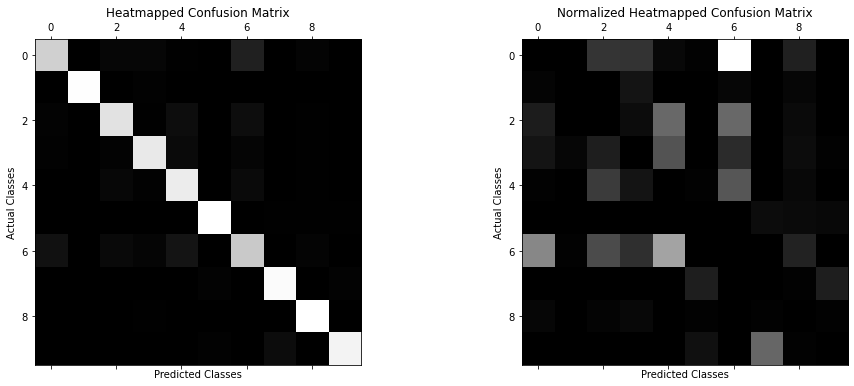

In [ ]:
heatmap_cm(model)

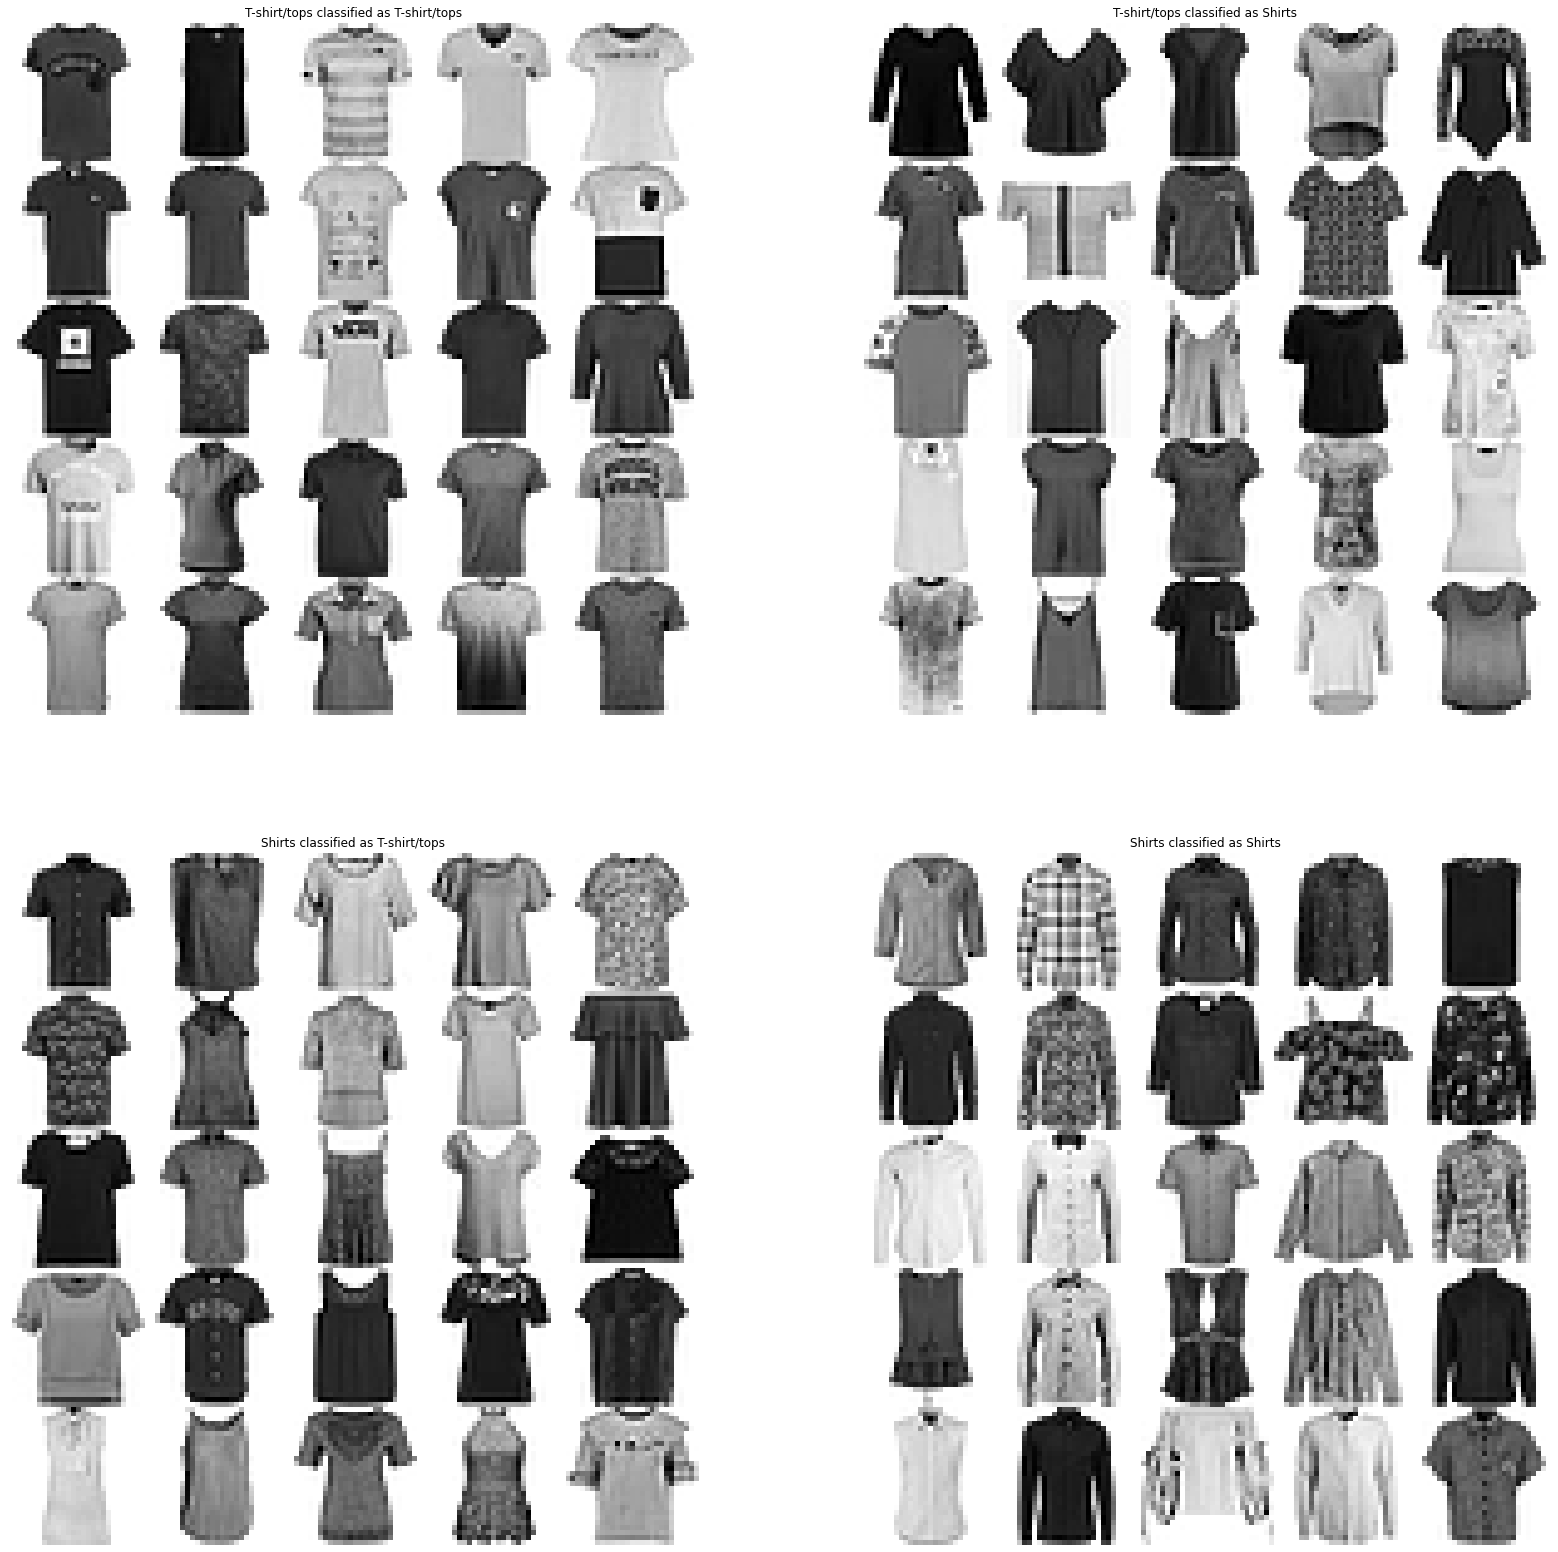

In [ ]:
plot_clothes(model, 0, 6)

The stacking of convolutional layers in this model has increased the capacity of the model dramatically, but at the same time, it has made overfitting a more serious problem here than it has been in any of the previous models. This model has also reverted to having difficulty distinguishing between the 'Shirts' and 'T-shirt/tops' classes as opposed to the previous model's difficulty distinguishing between the 'Shirts' and 'Coats' classes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


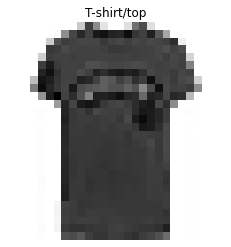

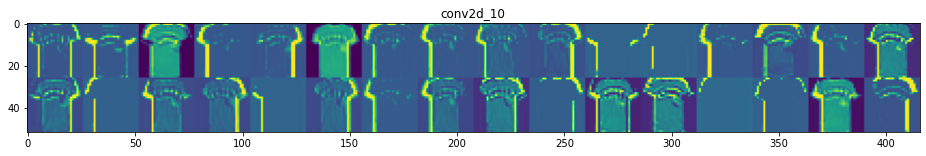

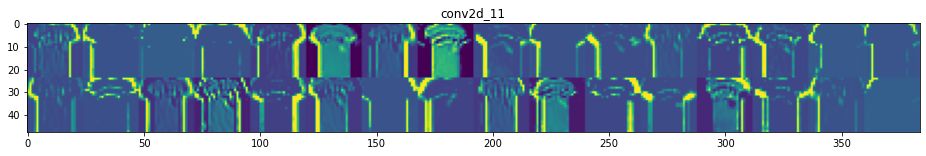

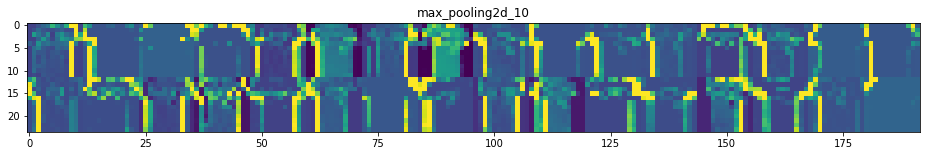

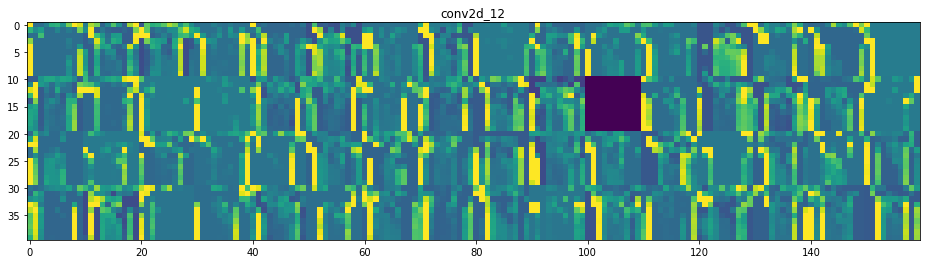

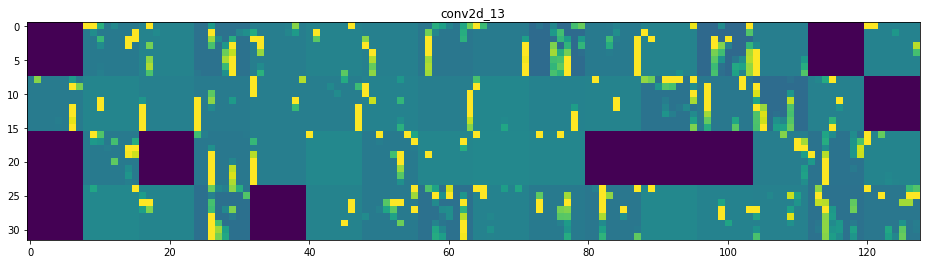

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


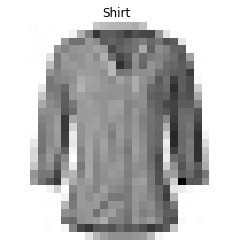

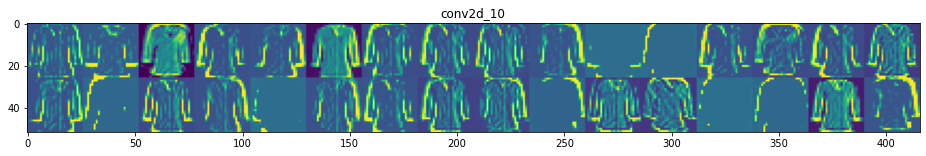

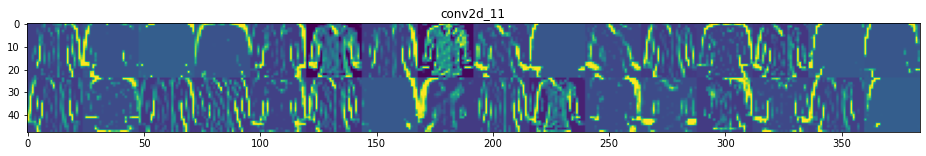

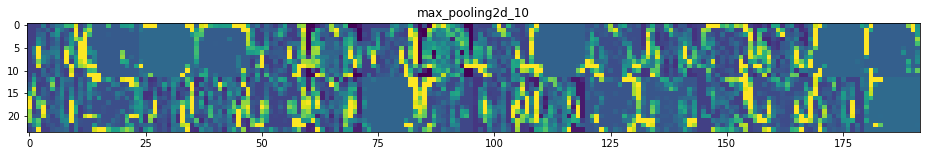

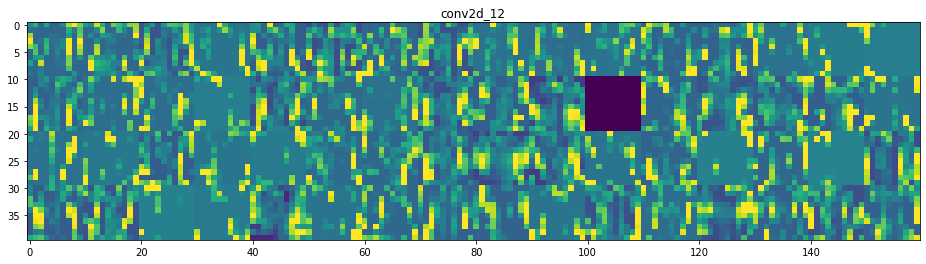

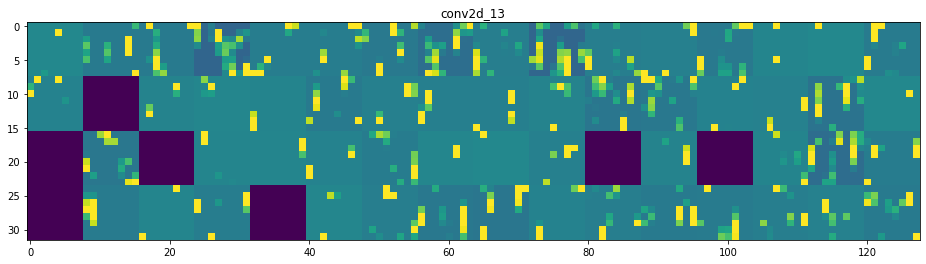

In [ ]:
conv_layer_plots(model, 6)

The general hue of these two plots is starting to shift from green to purple. Although these plots aren't entirely yellow outlines on purple backgrounds, they have a much darker overall coloring than the earlier models in this CNN section. This is reflected in the model's performance on the training data - the model's understanding of the images in this dataset is becoming more refined, and thus some of the noise that has persisted in the activation values until this point is starting to be stripped away. 

### CNN with 2 Blocks of 2 Convolutional Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 64)         

313/313 [==============================] - 1s 2ms/step - loss: 0.2706 - accuracy: 0.9231
Test Set Accuracy: 92.31


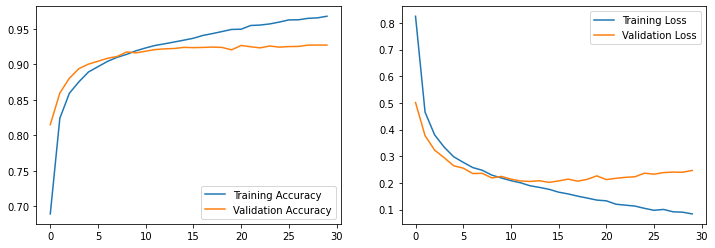

In [ ]:
evaluate_model(model, history, epochs)

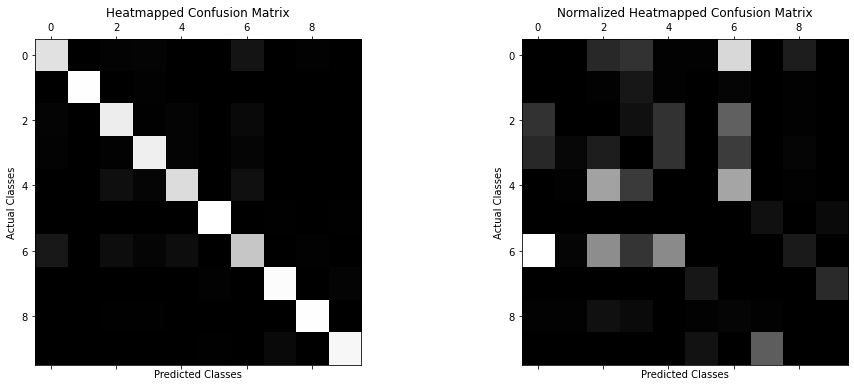

In [ ]:
heatmap_cm(model)

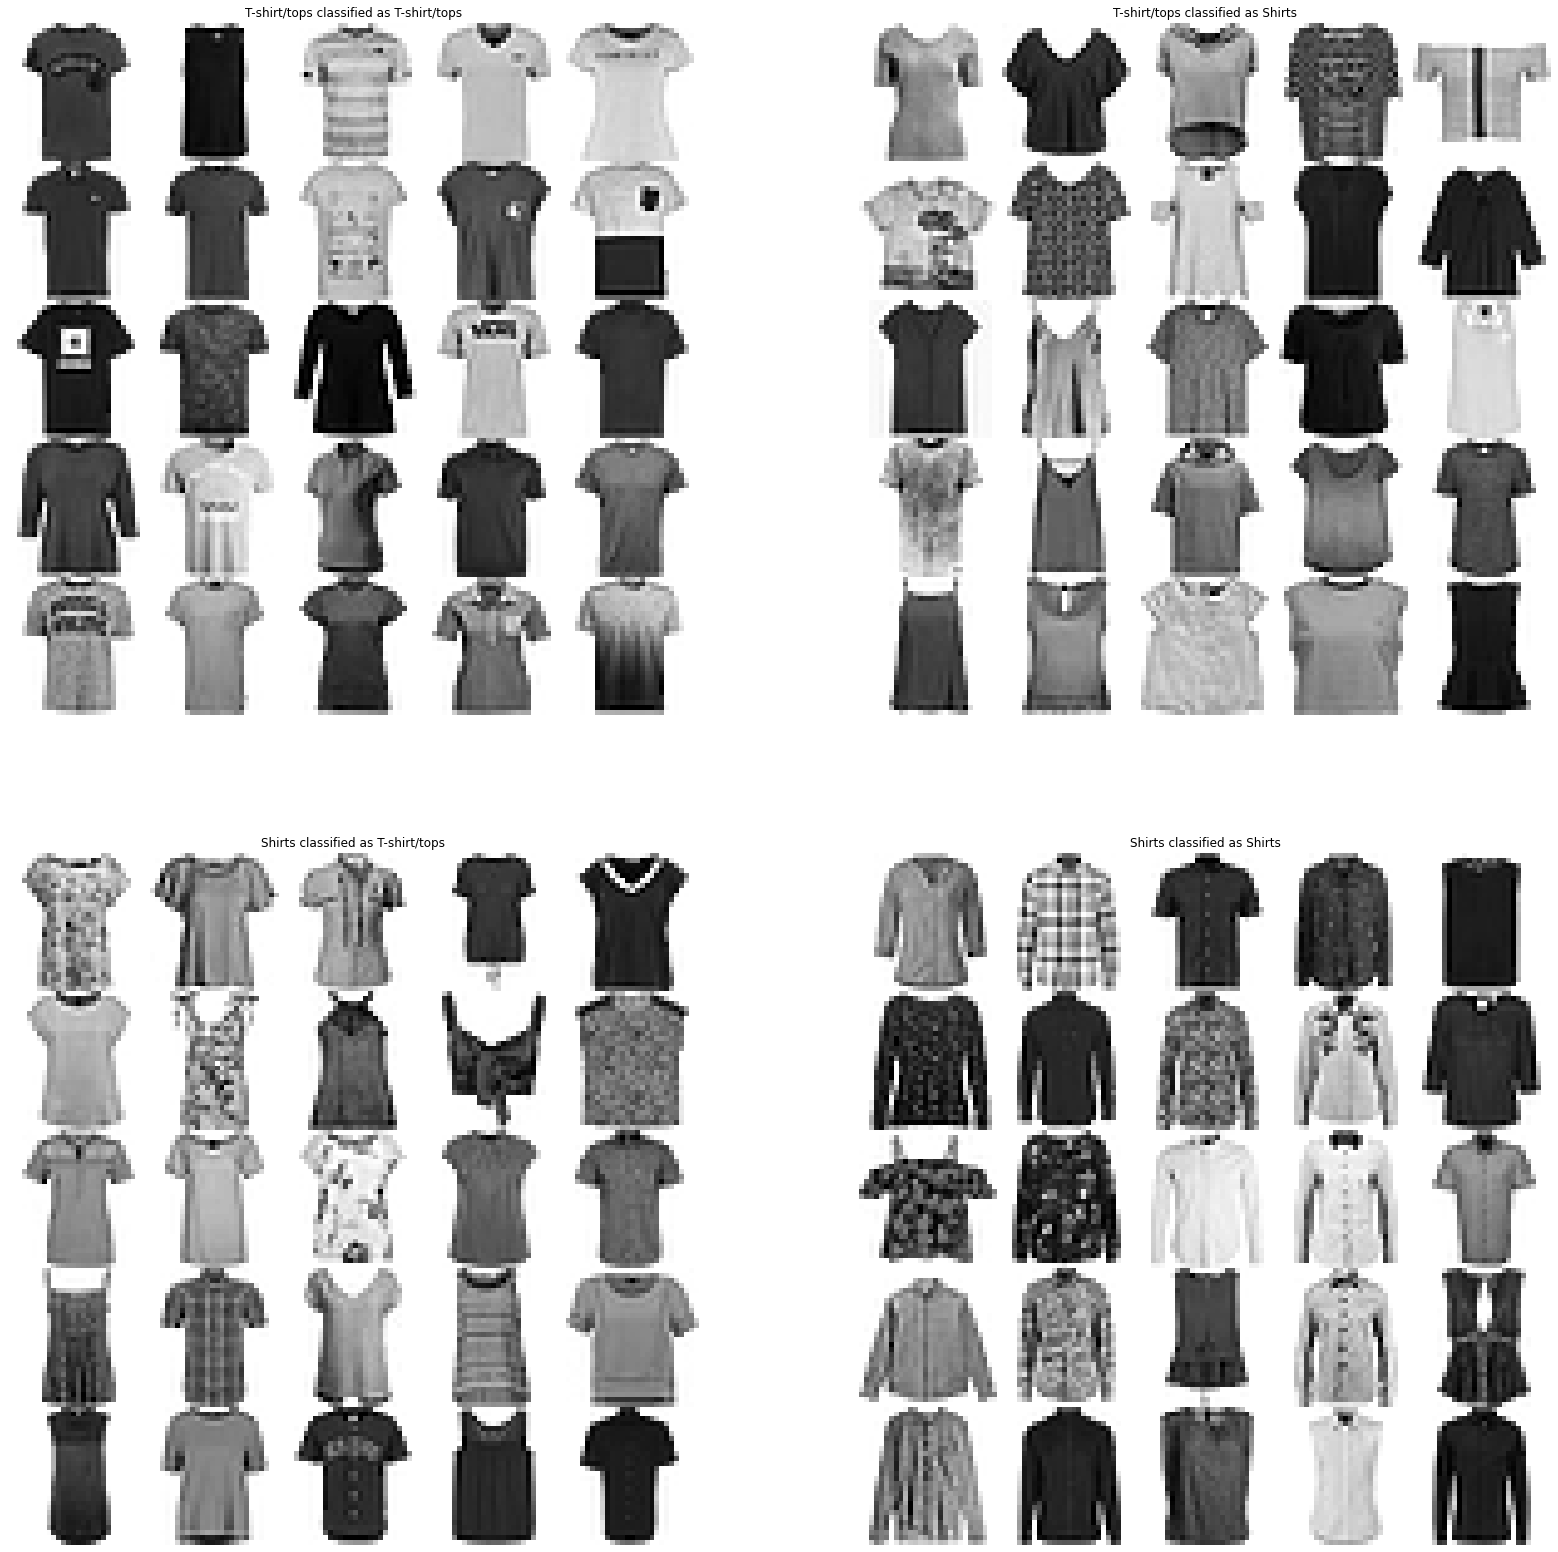

In [ ]:
plot_clothes(model, 0, 6)

This model is the best-performing model in terms of validation accuracy thus far. Despite the drop off in training set accuracy by about 2.4%, the inclusion of dropout regularization has bumped up the test set accuracy of the non-dropout model by roughly a full percentage point. The model still starts to overfit around the 15th epoch, but it's not so severe that the model does not generalize fairly well.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


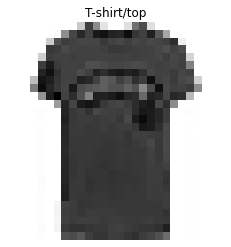

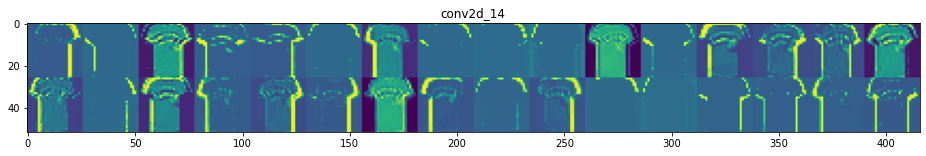

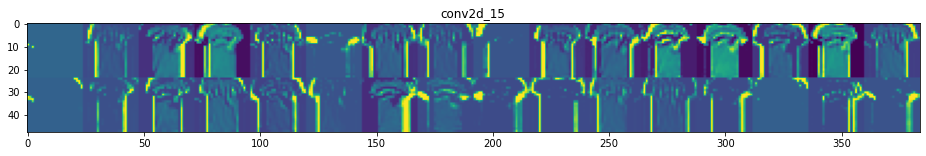

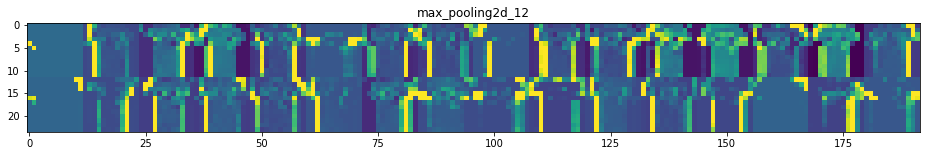

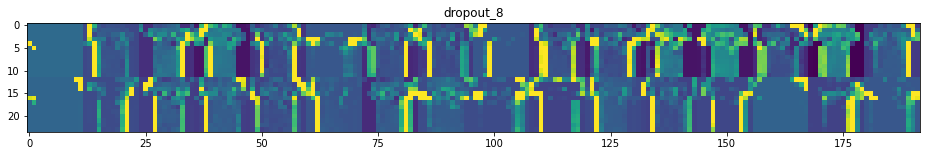

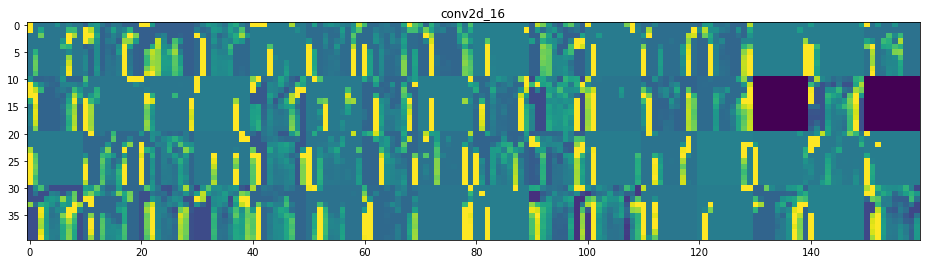

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


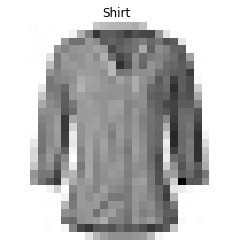

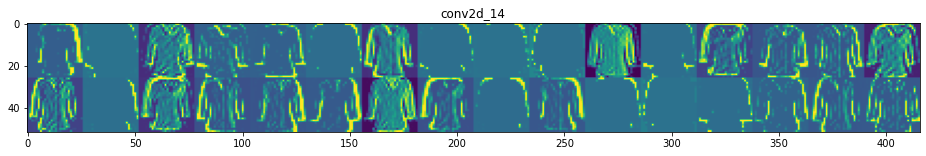

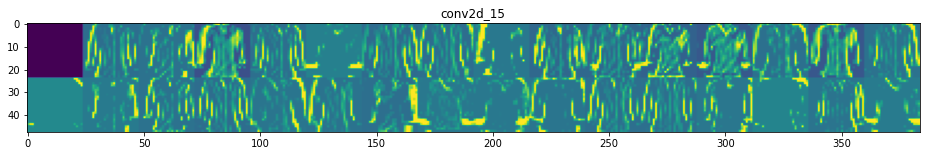

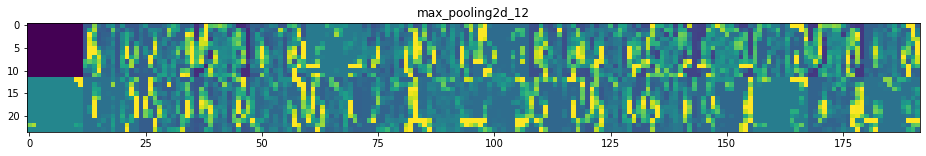

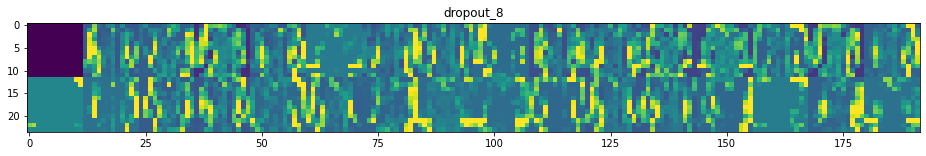

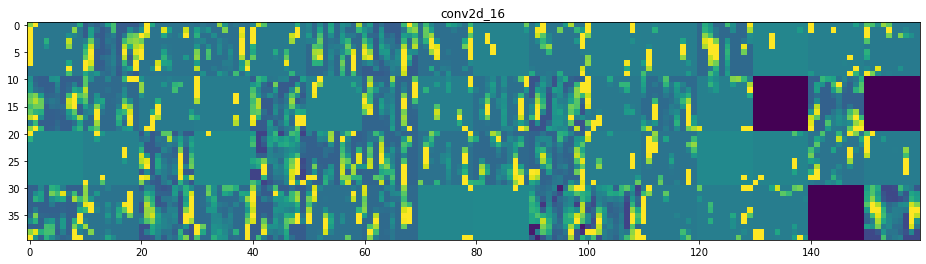

In [ ]:
conv_layer_plots(model, 6)

These two plots of the convolutional layers during the prediction of the 'Shirts' class and the 'T-shirt/tops' class are an interesting mix of precision and generalizability, especially in the top most layers. In the top most layer in each set of plots, the hue is somewhere between yellow and purple; the model has refined the boundaries of the articles of clothing to some extent, but it has not fallen into having a completely narrow understanding of each of these classes. This sort of refinement is also made evident by the relative sparsity of large activations in some of these views, indicating that the model is learning specific parts of the outlines of the articles of clothing.  

### CNN with 3 Blocks of 2 Convolutional Layers and No Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

313/313 [==============================] - 1s 3ms/step - loss: 0.5273 - accuracy: 0.9092
Test Set Accuracy: 90.92


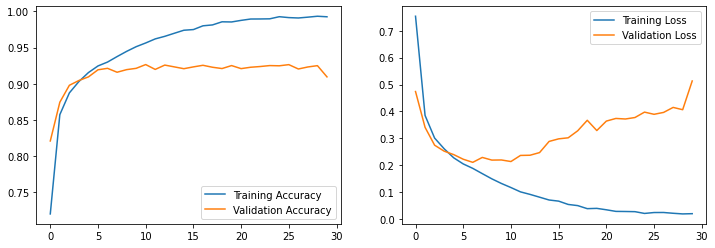

In [ ]:
evaluate_model(model, history, epochs)

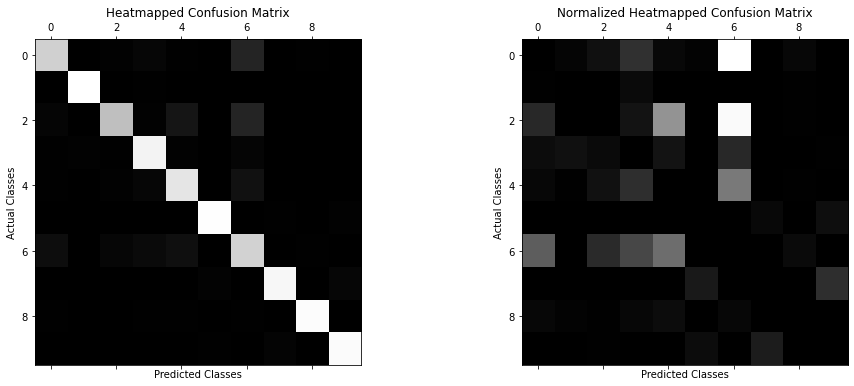

In [ ]:
heatmap_cm(model)

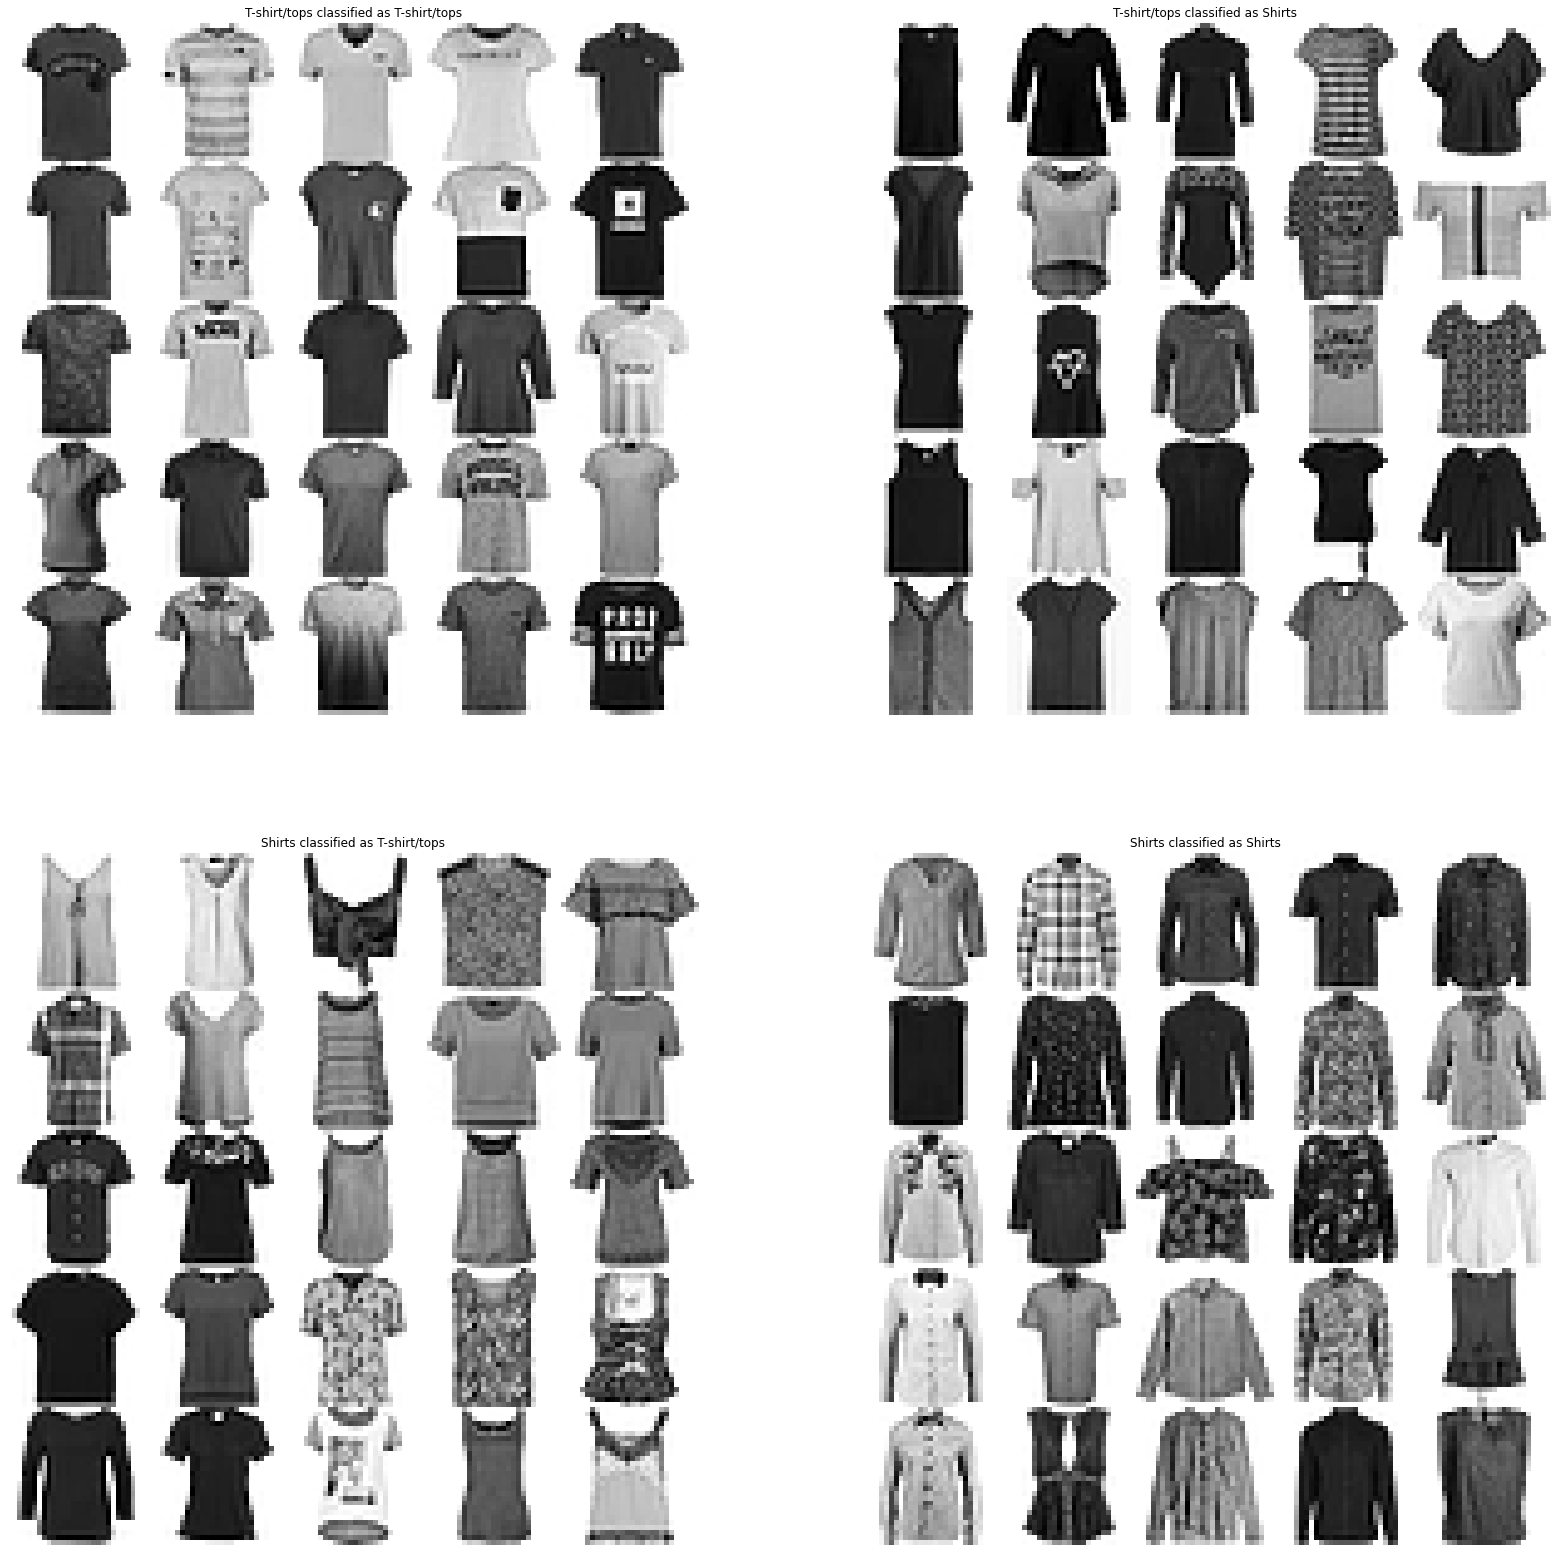

In [ ]:
plot_clothes(model, 0, 6)

The added block of convolutional layers here does provide a lift in training accuracy, but with that lift comes appreicable overfitting, as reflected in a test set accuracy poorer than that of the previous model. Depending on how this architecture fares with dropout regularization, the addition of a third block of convolutional layers may or may not be necessary.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


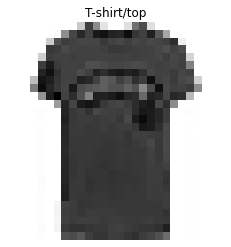

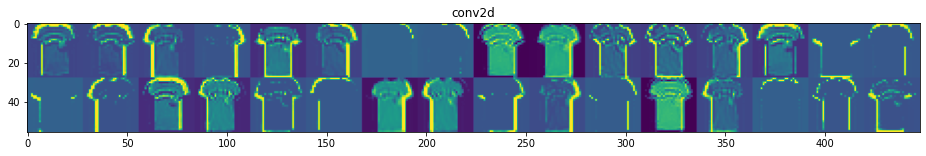

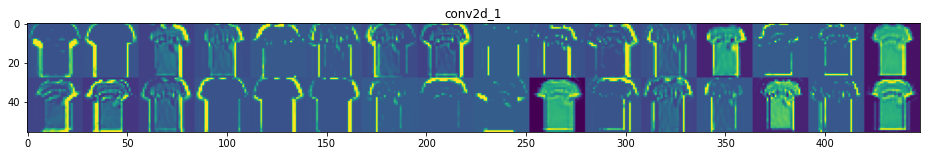

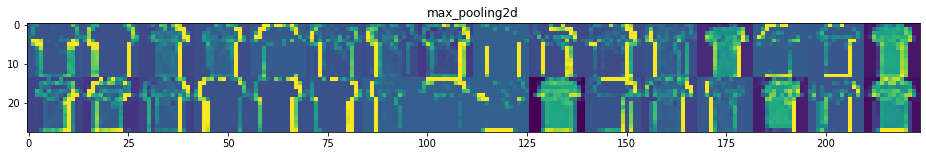

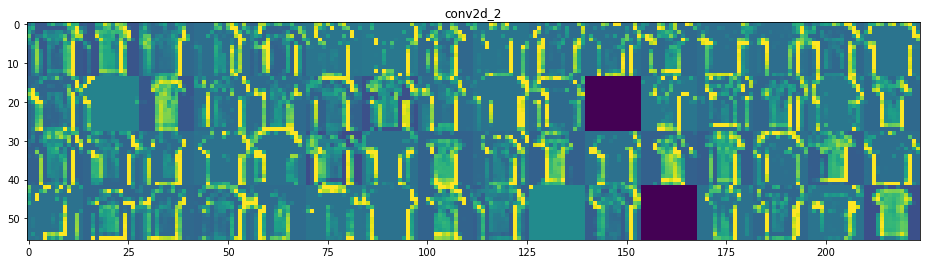

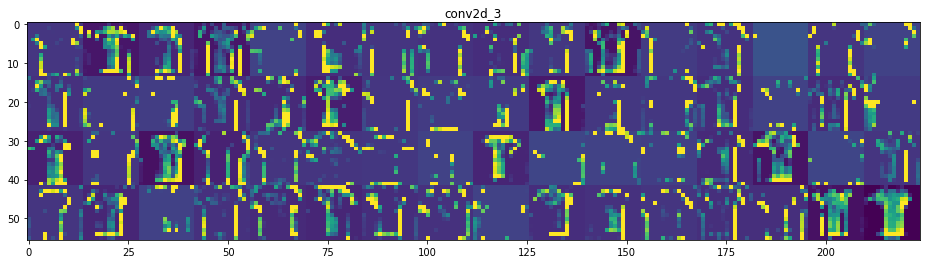

In [ ]:
conv_layer_plots(model, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


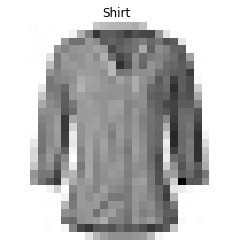

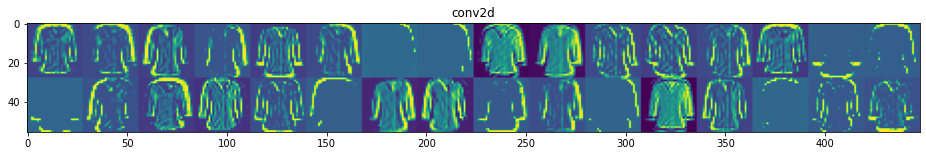

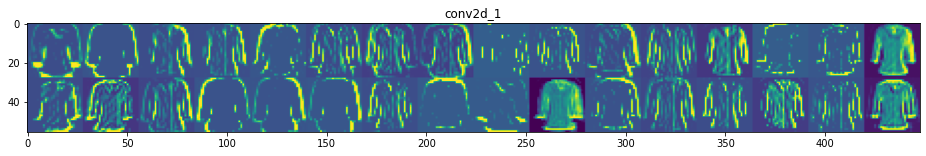

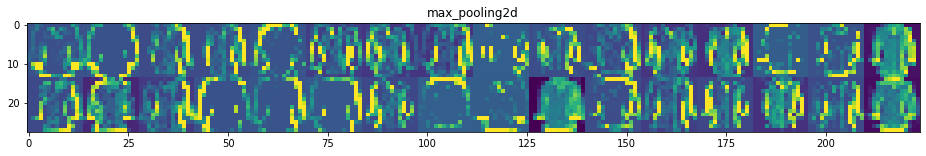

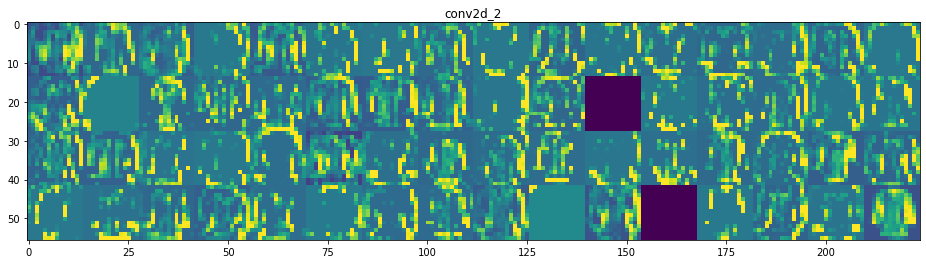

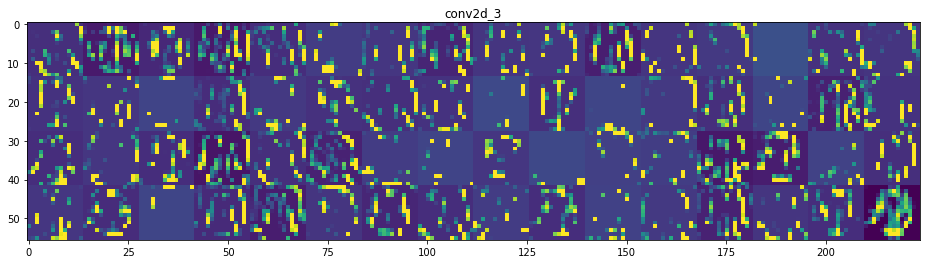

In [ ]:
conv_layer_plots(model, 6)

To some extent with the 'Shirts' class, but espcially in the case of the 'T-shirt/tops' class, the model has learned to draw outlines of articles of clothing that are far more defined than previous models. The precisness of the outlining in the 'T-shirt/tops' class appears to be causing the model some trouble when predicting this class, though. It seems that this narrow view of the class at times leaves the model thinking that images that do belong to this class might instead be part of the less narrowly-defined 'Shirts' class. 

### CNN with 3 Blocks of 2 Convolutional Layers and 20% Dropout

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
                             tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')])

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images_norm, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images_norm, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

313/313 [==============================] - 1s 2ms/step - loss: 0.2297 - accuracy: 0.9295
Test Set Accuracy: 92.95


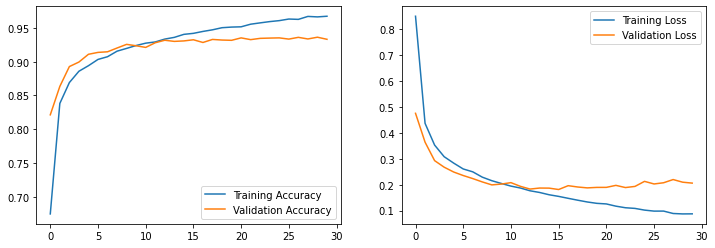

In [ ]:
evaluate_model(model, history, epochs)

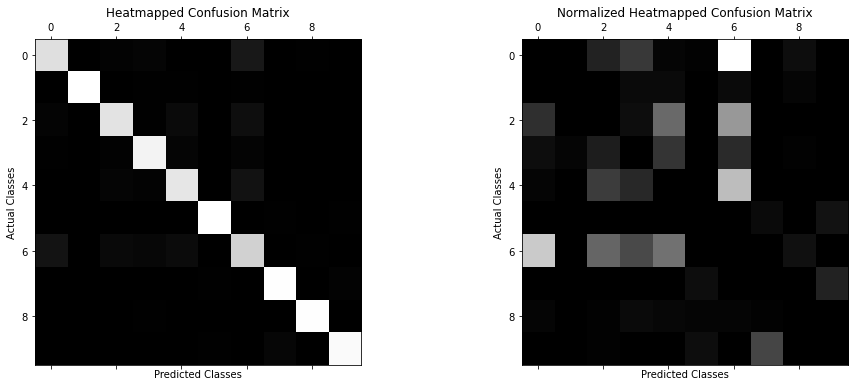

In [ ]:
heatmap_cm(model)

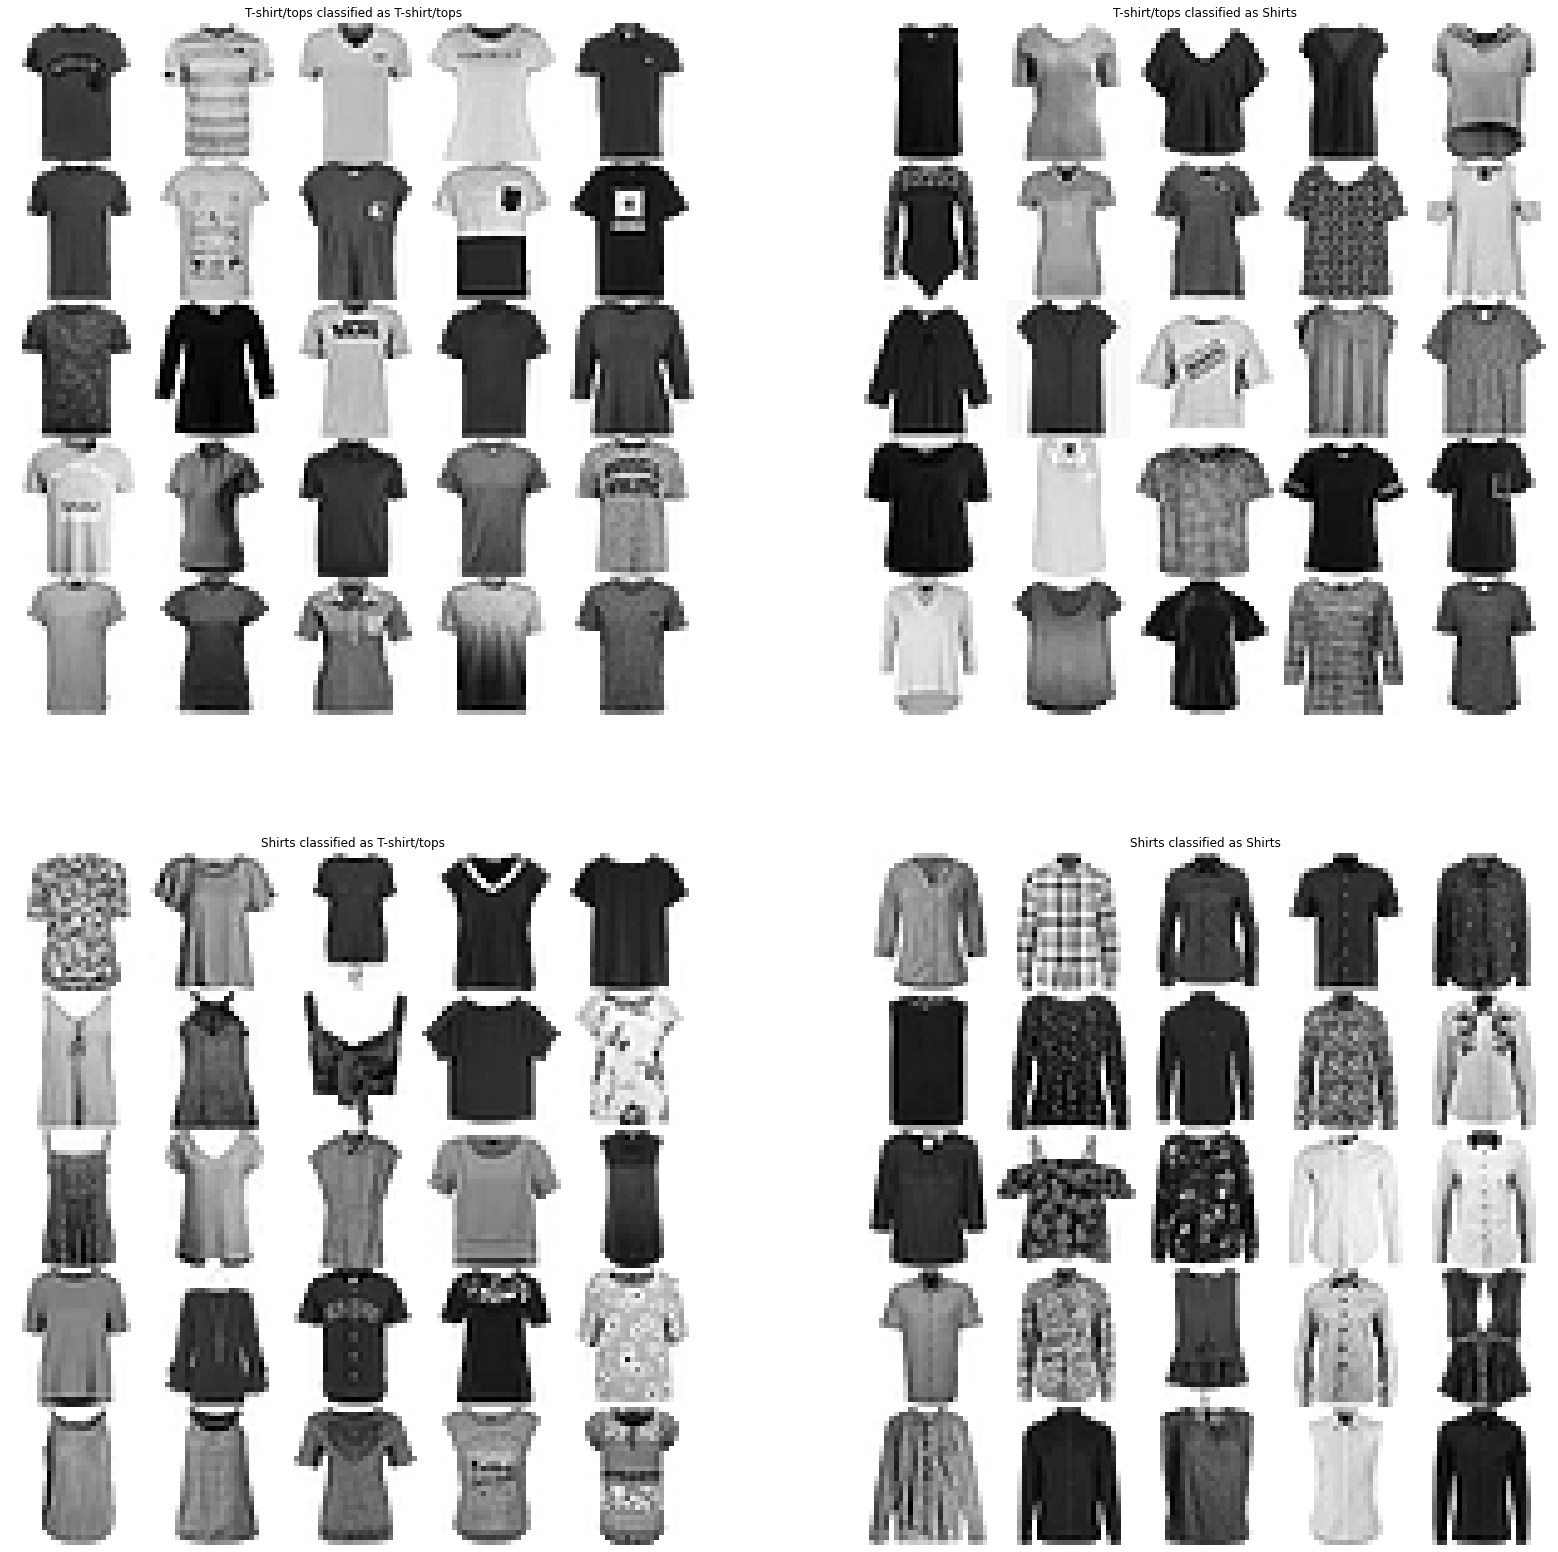

In [ ]:
plot_clothes(model, 0, 6)

As was the case with the two-block model, including dropout regularization slightly limits the capacity of the model, at least in terms of its training accuracy. However, this model did achieve that highest test set accuracy of any of the models studied, coming in at just about 93%. This is a roughly 3.5% improvement over the best-performing DNN model, too. 

Again, the difficulty in distinguishing between the 'Shirts' and 'T-shirt/tops' classes still persists, but this seems to have more to do with the model's narrow understanding of the 'Shirt' classes as opposed to a mix-up between articles of clothing with and without sleeves.

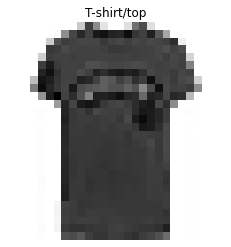

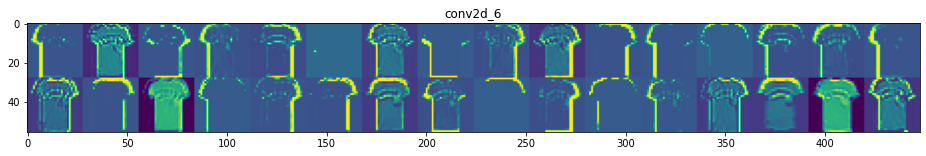

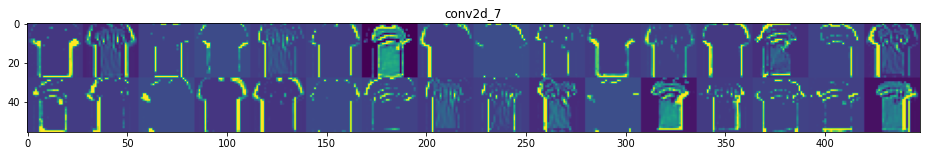

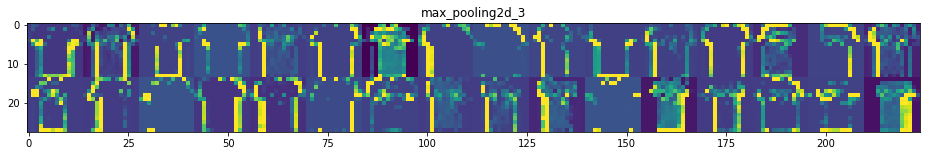

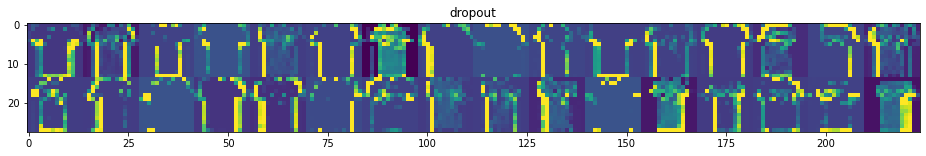

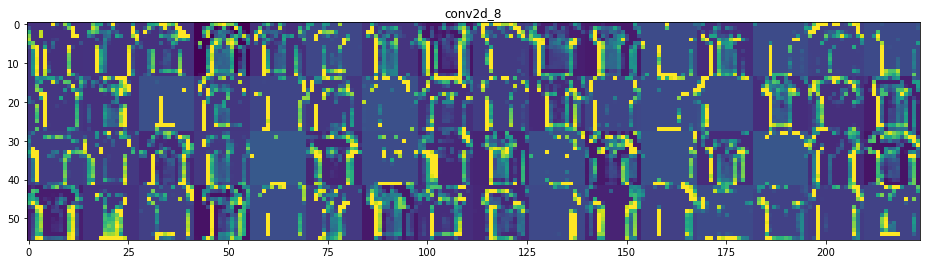

In [ ]:
conv_layer_plots(model, 0)

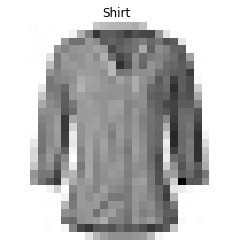

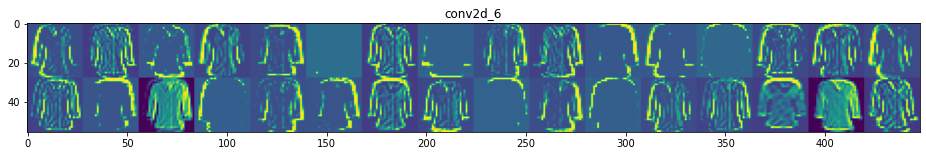

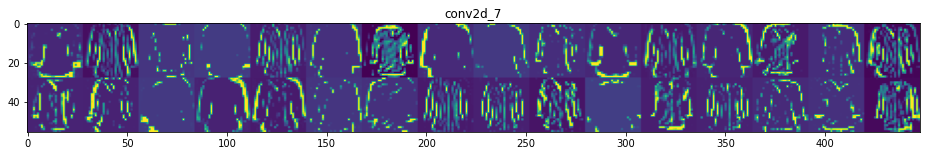

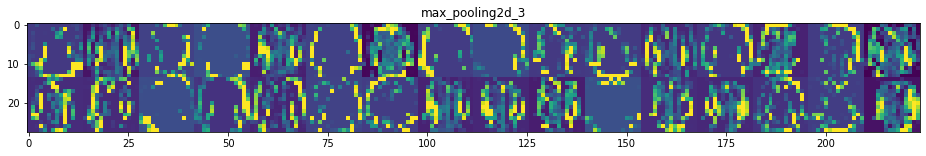

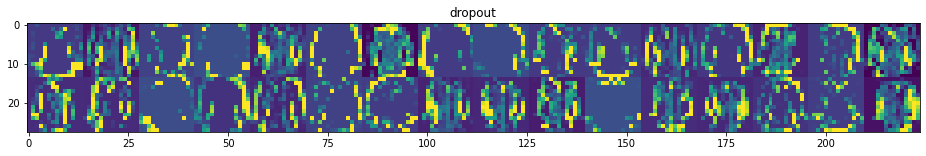

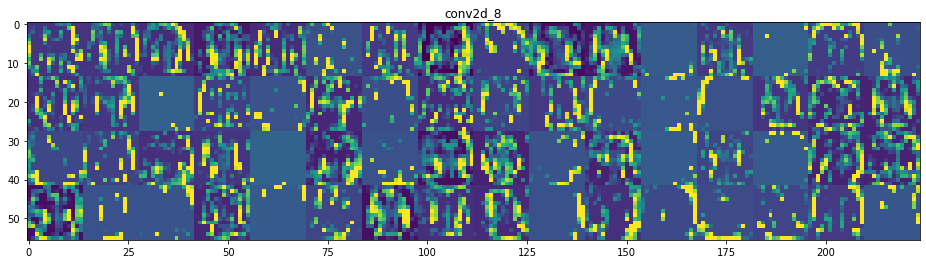

In [ ]:
conv_layer_plots(model, 6)

The plots here are about as purple-tinted as they have been yet, meaning that the model is honing in on specific understandings of the various classes. Where that differs between the 'Shirts' and 'T-shirt/tops' classes is in the torso area of theses images. It appears that activation values for the 'T-shirt/tops' class are most prominent at the edges of the articles of clothing in this class and nearly absent within the actual articles. As for the 'Shirts' class, the prominence of the activation values is more spread out throughout the image, meaning that this understanding of 'Shirts' likely generalizes better than the model's understanding of 'T-shirt/tops'.